# Assignment  2: Classification problem

Using previously classified comments, generate **at least** two types of classifers to detect positive and negative comments. 

Note that you can generate new features or classes.

## My approach to the problem, the tasks performed and the main conclusions by iteration


### Set the benchmarks

* Minimum: Above 69% of Accuracy, f1-score of 37% and 80% for negatives and positive sentiment, respectively.

* Benchmark: Above 80% of Accuracy (convention, because is the same understanding as humans) and 80% of roc-auc score

### Iteration three: Use the POS and the negation marking ideas, almost same results as common aprouch

* **the negation marking idea: **

    * The method is due to Das and Chen 2001 and Pang, Lee, and Vaithyanathan 2002 and is objective is approximating the effects of negation. It works appending a _NEG suffix to every word appearing between a negation and a clause-level punctuation mark.
    
    * **reference: *<http://sentiment.christopherpotts.net/lingstruc.html>***

#### Results


* **Main Conclusions: **

    * The solution doesn't change our first iteration result with the common approuch. It's provides a result above the minimum but under the benchmark, so it's a good result but not the one that we are looking for. This result is capable to classify with 73% of accuracy, 80% of precision for the positive sentiment and 0.71 of roc-auc score. However, the model is still not able to correctly classify both classes in a balanced way, we can see that when we compare the F1-score of the positive class (83%) which is twice as the negative (41%) and the roc-auc score is in a range considered regular.


* **The tasks made in this iteration to get that result was**:
   * ** Create the function clean_text for pre-process the text using regex: **
   
       * Get rid of newlines
       * Get rid of the accent marks
       * Replace the newlines that are attached to a word with only the word
       * Get rid of the symbols before the ' with the word in the sentence. Examples: \'t, \'m , etc
       * Replace twitter @mentions
       * Replace twitter user names
       * Replace hashtags
       * Replace numbers
       * Replace phone numbers
       * Replace HTML symbols
       * Delete especial characters and some HTML symbols
       * Get only one space of separation when there is one or more spaces
       
   
   * **Create the following features: **
   
       * For each row in the datset we will get the following numercial features:
        * Number of words with the variable name n_words
        * Number of sentences with the variable name n_sentences
        * Number of entities with the variable name n_entities
        * Number of words writen with only capitals letters with the variable name n_capitals
        * Number of positive emojis
        * Number of negative emojis
        * Polarity of the emojis
        * Number of exclamations (! or ¡) with the variable name n_exclamations
        * Number of ask signs (? or ¿) with the variable name n_ask_signs
        * Number of qualifying adjective's (POS with the value ADJ and TAG's with the value JJ)
        * Number of verbs (POS with the value VERB)
        * A column with the POS (part of speech tagging) and TAG's for each token in the text
        * A column with the entities in the text (Name entitie recognition)
        * Number of negations in the sentence
        
    * **Create the negation marks: **
   
       * The original rule is append a _NEG suffix to every word appearing between a negation and a clause-level
       punctuation mark. 
       
       * Another rule was implemented, since the text of this data has a lot documents without puntuaction mark. The 
       rule created detects a negation word and append a _NEG suffix to the the negation word and also to the following 
       three nexts words. The idea behind this, it's that usually between the next three word the verbs and adjectives 
       are mentioned and this kind of words are the most relevant features (usually) for the sentiment analysis
       
    * **Putting all together: POS + the negation marks: **
    
        * In the final part of this iteration, the token_POS idea was applied using the custom function spacy_tokenizer 
        as a paramater for the CountVectorizer object. This was implement in all the words which already has the 
        negation mark too, so the structure of the resultant token could be: token_POS or token_NEG_POS depending if is 
        a word marked as a word used in a negation context or not.


** IMPORTANT: The functions created to acomplish all this tasks were created and are declared before to apply it just to make the review a litle bit easy. Ussualy this will be at the beginning of the notebook**

## Disclaimer

* After i complete my second iteration with the model and get 72% of Accuracy and 0.71 roc-auc score, i post this in
  the Big Data and Data Science comunnity asking for ideas to make an improvement in the model. I did recieve help
  with ideas but all the implementation of them i made it myself, so it's the same as read a blog or any post on the
  internet.If you want to check the ideas that i recieved, you can go to this link:

*<https://www.facebook.com/groups/big.data.science.chile/permalink/2009665029359437/>*

* In any case, if you consider that it was not appropriate to receive help with ideas to implement, I separated the solution into version one and the others, so that you can evaluate only the first version, if you deem it convenient.


* Also, i use the vaderPackage to set up a minimium threshold to the accuracy of the model after read some ideas in the post. Before that, my benchmark was only get to the accuracy of 80%, which is the standar benchmark un sentiment analysis to say that is a very good model (convention, because is the same understanding as humans)

In [1]:
%matplotlib inline  
import pandas as pd
import numpy as np
from itertools import chain
import re
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer        
from nltk.stem import WordNetLemmatizer 
import spacy
import string
import emoji
from time import time
from collections import Counter
# Library's to plot
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000000 # Jupyter notebook backend restricts number of points in plot
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline') 
get_ipython().magic(u"config InlineBackend.figure_format='retina'")
import plotly.plotly as py
from plotly import graph_objs
from plotly.graph_objs import Figure,Layout,Scatter,Bar
# Library's to apply balance technic's
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the necessary module's
from sklearn.preprocessing import binarize,MinMaxScaler,RobustScaler,normalize,MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_selection import  mutual_info_classif,chi2,RFE,RFECV,SelectFromModel
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_validate,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,average_precision_score
from sklearn.metrics import log_loss,roc_curve,classification_report,confusion_matrix,make_scorer
# Init the spacy object call parser
import warnings
warnings.filterwarnings('ignore')
# Init the spacy object call parser
parser = spacy.load("en")

In [2]:
def variable_selection(X,y):
    
    # Generamos la métrica de mutual information de los features con respecto al Score 
    mi = mutual_info_classif(X,y,random_state=0,discrete_features='auto')
    # Creamos el dataframe con los resultados
    raw_data={'features':X.columns.values,'m-score':mi,'m-weight':mi/np.max(mi)}
    features_mi=pd.DataFrame(raw_data,columns=['features','m-score','m-weight'])
    features_mi=features_mi.sort_values(by='m-weight',ascending=False)
    
    # Generamos el el clasificador con Random Forest
    clf = RandomForestClassifier(
        bootstrap=True, criterion='gini',max_features='sqrt',min_samples_split=20,
        n_estimators=500,random_state=0,warm_start=True,n_jobs=-1, min_samples_leaf =20)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Random Forest
    rfe_rf = RFE(clf, n_features_to_select=1)
    fit_rf = rfe_rf.fit(X, y)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'ranking_ffe_rf':fit_rf.ranking_}
    features_ffe_rf=pd.DataFrame(
        raw_data,columns=['features','ranking_ffe_rf']).sort_values(by='ranking_ffe_rf',ascending=True)
    selected_features=pd.merge(left=features_mi,right=features_ffe_rf, how='left', on='features', 
                               sort=False,suffixes=('_mi', '_ffe_rf'), copy=True, indicator=False)
    
    # Generamos el el clasificador con Regresión logística
    model = LogisticRegression(random_state=0,warm_start=True)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Regresión Logística
    rfe_lr = RFE(model, n_features_to_select=1)
    fit_rl = rfe_lr.fit(X, y)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'ranking_ffe_rl':fit_rl.ranking_}
    features_ffe_rl=pd.DataFrame(
        raw_data,columns=['features','ranking_ffe_rl']).sort_values(by='ranking_ffe_rl',ascending=True)
    selected_features=pd.merge(left=selected_features,right=features_ffe_rl, how='left', on='features', left_on=None, 
                               sort=False,suffixes=('', '_ffe_rl'), copy=True, 
                               indicator=False)
    
    # Generamos el el clasificador con Gradient Boosting
    model = GradientBoostingClassifier(
        random_state=0,max_features='sqrt',subsample=0.8,learning_rate=0.01,
        n_estimators=500,min_samples_split = 20,warm_start=True,presort=True)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Gradient Boosting
    rfe_gb = RFE(model, n_features_to_select=1)
    fit_gb = rfe_gb.fit(X=X, y=y)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'ranking_ffe_gb':fit_gb.ranking_}
    features_ffe_gb=pd.DataFrame(
        raw_data,columns=['features','ranking_ffe_gb']).sort_values(by='ranking_ffe_gb',ascending=True)
    selected_features=pd.merge(left=selected_features,right=features_ffe_gb, how='left', on='features',
                               suffixes=('', '_ffe_gb'), copy=True, indicator=False)
    
    # Generamos el el clasificador con Linear SVC
    lsvc = LinearSVC(C=0.01, penalty="l1", random_state=0,dual=False,
                     loss='squared_hinge').fit(X, y)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Linear SVC
    model = SelectFromModel(lsvc, prefit=True)
    X_new = model.transform(X)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'coef_svc':np.abs(lsvc.coef_[0])}
    features_svc=pd.DataFrame(raw_data,columns=['features','coef_svc']).sort_values(by='coef_svc',ascending=False)
    features_svc['ranking_svc']=range(1,len(lsvc.coef_[0])+1)
    selected_features=pd.merge(left=selected_features,right=features_svc, how='left', on='features',
                               sort=False,suffixes=('', '_svc_lineal'), copy=True, indicator=False)
    
    return selected_features

In [3]:
# Functions to select the best parameters for each model

# This function creates all the classifiers that will be used
def create_classifiers():
    classifier_LR = LogisticRegression(random_state=0,max_iter=200)
    #classifier_RF = RandomForestClassifier(n_estimators=200,random_state=0,n_jobs=-1)
    classifier_BNB = BernoulliNB(binarize=0)
    classifier_MNB = MultinomialNB()
    classifier_linearSVC=LinearSVC(random_state=0,dual=True,penalty='l2')
    classifier_SVC = SVC(kernel='rbf',probability=True,max_iter=200,random_state=0)
    #classifier_GB = GradientBoostingClassifier(random_state=0,subsample=0.8,n_estimators=200,presort=False)
    algorithms=[classifier_LR,classifier_BNB,classifier_MNB,classifier_linearSVC,classifier_SVC]
    
    return algorithms

# This function creates the parameters which will be tested for each algorithm
def create_parameters():
    parameters_LR = {'warm_start':[True,False],'C':[0.01,0.1,0.5,1,5,10],'class_weight':[None,'balanced']}
    #parameters_RF = {'bootstrap':[True,False],'criterion':['gini','entropy'],'max_features':['sqrt','auto','log2'],
    #                 'warm_start':[True,False],'min_samples_split':[2,25,75],
    #                 'min_samples_leaf':[2,25,75],'class_weight':[None,'balanced']}
    parameters_BNB = {'class_prior':[[np.float64(0.259),np.float64(0.741)],[0.5,0.5]],'alpha':[0.001,0.01,0.1,0.5,1],
                      'fit_prior':['True','False']}
    parameters_MNB = {'class_prior':[[np.float64(0.259),np.float64(0.741)],[0.5,0.5]],'alpha':[0.001,0.01,0.1,0.5,1],
                      'fit_prior':['True','False']}
    parameters_linearSVC={'C':[0.01,0.1,0.5,1],'loss':['hinge','squared_hinge']}
    
    parameters_SVC = {'C':[0.1,1, 10]}
    
    #parameters_GB = {'max_features':['sqrt','auto','log2'],'warm_start':[True,False],
    #                 'min_samples_split':[2,25,750]}
    
    parameters=[parameters_LR,parameters_BNB,parameters_MNB,parameters_linearSVC,parameters_SVC]
    
    return parameters

# This function execute the GridsearchCV with for all the algorithms wich the parameters given and return
# the main metrics for binary classification problems and the best parameters 
def get_best_param(X_train,y_train,classifiers):
    params_metrics={}
    for i in range(0,len(classifiers)):
        classifiers[i].fit(X_train,y_train)
        params_metrics.update({classifiers[i].estimator.__class__.__name__:
                 {
                  'accuracy':classifiers[i].cv_results_.get('mean_test_accuracy')[classifiers[i].best_index_],
                  #'precision':classifiers[i].cv_results_.get('mean_test_precision')[classifiers[i].best_index_],
                  #'F1':classifiers[i].cv_results_.get('mean_test_F1')[classifiers[i].best_index_],
                  #'recall':classifiers[i].cv_results_.get('mean_test_recall')[classifiers[i].best_index_],
                  #'roc-auc':classifiers[i].cv_results_.get('mean_test_roc-auc-score')[classifiers[i].best_index_],
                  'best_params':classifiers[i].best_params_
                 }
                })
        
    return params_metrics

In [4]:
# Functions to restart the classifiers with the the best parameters selected for each model

def restart_classifiers(best_parameters):
    classifier_LR = LogisticRegression(
        random_state=0,max_iter=300,C=best_parameters.get('LogisticRegression').get('best_params').get('C'),
        class_weight=best_parameters.get('LogisticRegression').get('best_params').get('class_weight'),
        warm_start=best_parameters.get('LogisticRegression').get('best_params').get('warm_start')
    )
    
    #classifier_RF = RandomForestClassifier(
    #    n_estimators=300,random_state=0,n_jobs=-1,
    #    bootstrap=best_parameters.get('RandomForestClassifier').get('best_params').get('bootstrap'),
    #    criterion=best_parameters.get('RandomForestClassifier').get('best_params').get('criterion'),
    #    max_features=best_parameters.get('RandomForestClassifier').get('best_params').get('max_features'),
    #    min_samples_split=best_parameters.get('RandomForestClassifier').get('best_params').get('min_samples_split'),
    #    warm_start=best_parameters.get('RandomForestClassifier').get('best_params').get('warm_start'),
    #    min_samples_leaf=best_parameters.get('RandomForestClassifier').get('best_params').get('min_samples_leaf'),
    #    class_weight=best_parameters.get('RandomForestClassifier').get('best_params').get('class_weight')
    #)
    
    classifier_RF = RandomForestClassifier(
        bootstrap=True, criterion='gini',max_features='sqrt',
        min_samples_split=50,n_estimators=300,random_state=0,
        warm_start=True,n_jobs=-1, min_samples_leaf =50)
    
    classifier_BNB=BernoulliNB(
        binarize=0,
        fit_prior=best_parameters.get('BernoulliNB').get('best_params').get('fit_prior'),
        class_prior=best_parameters.get('BernoulliNB').get('best_params').get('class_prior'),
        alpha=best_parameters.get('BernoulliNB').get('best_params').get('alpha')
    )
    
    classifier_MNB = MultinomialNB(
        fit_prior=best_parameters.get('MultinomialNB').get('best_params').get('fit_prior'),
        class_prior=best_parameters.get('MultinomialNB').get('best_params').get('class_prior'),
        alpha=best_parameters.get('MultinomialNB').get('best_params').get('alpha')
    )
    
    classifier_linearSVC=LinearSVC(
        random_state=0,dual=True,penalty='l2',
        C=best_parameters.get('SVC').get('best_params').get('C'),
        loss=best_parameters.get('LinearSVC').get('best_params').get('loss')
    )
    
    classifier_SVC=SVC(
        kernel='rbf',probability=True,max_iter=200,random_state=0,
        C=best_parameters.get('LinearSVC').get('best_params').get('C'),
    )
    
    #classifier_GB = GradientBoostingClassifier(
    #    random_state=0,subsample=0.8,n_estimators=300,presort=False,
    #    max_features=best_parameters.get('GradientBoostingClassifier').get('best_params').get('max_features'),
    #    min_samples_split = best_parameters.get('GradientBoostingClassifier').get('best_params').get('min_samples_split'),
    #    warm_start=best_parameters.get('GradientBoostingClassifier').get('best_params').get('warm_start'))
    
    classifier_GB = GradientBoostingClassifier(
        random_state=0,max_features='sqrt',subsample=0.8,learning_rate=0.01,n_estimators=300,
        min_samples_split = 40,warm_start=True,presort=False)
    
    algorithms=[classifier_LR,classifier_RF,classifier_BNB,classifier_MNB,classifier_linearSVC,
                classifier_SVC,classifier_GB]
    
    return algorithms

In [5]:
def train_classifier(X_train, y_train, X_test, models,scoring,probs=False):
    #create table to compare the metrics between each model
    compare_table_columns = [
    'Algorithm', 'Test average-precision','Test Accuracy Mean',
    'Test Accuracy 3*STD','Test F1','Test Recall','Parameters','Time']
    compare_table = pd.DataFrame(columns = compare_table_columns)
    #create table to compare predictions between each model
    compare_table_predict= {'real values': {'prediction':[list(y_train)]}}
    row_index = 0
    for alg in models:
        #set name and parameters
        table_name = alg.__class__.__name__
        compare_table.loc[row_index, 'Algorithm'] = table_name
        compare_table.loc[row_index, 'Parameters'] = str(alg.get_params())
        
        #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
        cv_results = cross_validate(estimator=alg,X=X_train,scoring=scores,y=y_train, 
                                    cv = 10,return_train_score=False)
        compare_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()
        compare_table.loc[row_index, 'Test average-precision'] = cv_results['test_average-precision'].mean()
        compare_table.loc[row_index, 'Test Accuracy Mean'] = cv_results['test_accuracy'].mean()   
        #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
        compare_table.loc[row_index, 'Test Accuracy 3*STD'] = cv_results['test_accuracy'].std()*3   #let's know the worst that can happen!
        compare_table.loc[row_index, 'Test Recall'] = cv_results['test_recall'].mean() 
        compare_table.loc[row_index, 'Test F1'] = cv_results['test_F1'].mean()
        #compare_table.loc[row_index, 'Test Roc-Auc Mean'] = cv_results['test_roc-auc-score'].mean()

        #save predictions
        alg.fit(X_train, y_train)
        compare_table_predict.update({table_name: {'prediction':alg.predict(X_test)} })
        
        row_index+=1
    
    return [compare_table,compare_table_predict]

In [6]:
def test_classifier(X_train, y_train, X_test, y_test, classifier,probs=False):
    classifier_name = str(type(classifier).__name__)
    print("Testing " + classifier_name)
    now = time()
    list_of_labels = sorted(list(set(y_train)))
    model = classifier.fit(X_train, y_train)
    print("Learing time {0}s".format(time() - now))
    now = time()
    predictions = model.predict(X_test)
    print("Predicting values time {0}s".format(time() - now))
    if(probs):
        now = time()
        probs_prediction= model.predict_proba(X_test)
        print("Predicting probs time {0}s".format(time() - now))
        roc_auc   = roc_auc_score(y_test, probs_prediction[:,1])
    
    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    recall    = recall_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    accuracy  = accuracy_score(y_test, predictions)
    f1score   = f1_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    cr        = classification_report(y_test, predictions)
    cm        = pd.crosstab(y_test, predictions, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
    results   = {classifier_name: 
                 {
                     'F1':f1score,
                     'Precision':precision,
                     'Recall':recall,
                     'Accuracy':accuracy,
                 }
                }
    if(probs):
        results.update({classifier_name: {
            'F1':f1score,
            'Precision':precision,
            'Recall':recall,
            'Accuracy':accuracy,
            'Roc-Auc':roc_auc} })
        return [results,cr,cm, predictions, probs_prediction]
    else:
        return [results,cr,cm,predictions]

In [7]:
# A custom function to clean the text before sending it into the vectorizer
# A custom function to clean the text before sending it into the vectorizer
def cleanText(text):
    
    # delete links
    text = re.sub(pattern=r'https?:\/\/.*[\r\n]*',repl='URL', string=text, flags=re.MULTILINE | re.IGNORECASE)
    
    # get rid of newlines
    text = text.strip().replace("\n+|\n\n+|\r"," ")
    
    #get rid of the accent marks
    text=text.replace(u"\uFFFD",'')
    
    # Join the negation forms
    negation_finder=re.compile(r"""n't""",re.IGNORECASE)
    text=negation_finder.sub('nt',text)
    
    #Replace the newlines that are attached to a word with only the word
    newlines_finder=re.compile("\n\w+|\n\n\w+", re.IGNORECASE)
    w=newlines_finder.findall(text)
    for t in w:
        if len(t.split('\n\n'))>1:
            text=re.sub(t,t.split('\n\n')[1],text)
        else:
            text=re.sub(t,"",text)
    
    #get rid of the symbols before the ' with the word in the sentence. Examples: \'t, \'m , etc
    text=re.sub(r'\''," ",text)
    
    # replace twitter the symbol of the user names
    hashtag_finder = re.compile(r"(?:\@)", re.IGNORECASE)
    text = hashtag_finder.sub("", text)
    
    # replace hashtags
    hashtag_finder = re.compile(r"(?:\#)", re.IGNORECASE)
    text = hashtag_finder.sub("", text)
    
    # replace numbers
    number_finder =re.compile(r"\s?[0-9]+\.?[0-9]*")
    text = number_finder.sub(" NUMBER ", text)
    
    # Replace phone numbers
    phone_number_finder=re.compile(r"""
    (?:
      (?:            # (international)
        \+?[01]
        [\-\s.]*
      )?            
      (?:            # (area code)
        [\(]?
        \d{3}
        [\-\s.\)]*
      )?    
      \d{3}          # exchange
      [\-\s.]*   
      \d{4}          # base
    )""", re.IGNORECASE)
    text = phone_number_finder.sub(" ", text)
    
    # replace HTML symbols
    html_finder = re.compile(r'<.*?>')
    text=html_finder.sub('', text)
    
    # delete especial characters and some HTML symbols
    for remove in map(lambda r: re.compile(re.escape(r)),["\"", "=", "&", "%", "$", "%", "^", "*","(", ")", 
                       "{", "}","[", "]", "|", "/", "\\",">","<","-", "'",
                       "--", "---","&gt;","&lt;","-----", "---", "...", "“", "”", "'ve"]):
        text=remove.sub("",text)
    
    #Get only one space of separation when there is one or more spaces
    text=text.replace(r'\s',' ')

    return text

In [8]:
def tokenizer(doc,parser=parser,stem=False,lemma=True,stop_words=True,min_words=2,only_alpha=True,digit=True):
    
    doc = parser(doc)
    tokens=[token for token in doc if not (token.is_punct or token.is_space or token.is_quote)]
    
    if(not digit):
         tokens=[token for token in tokens if not (token.is_digit)]
    
    if(only_alpha):
        tokens=[token for token in doc if (token.is_alpha)]
    
    if(stop_words):
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if not (token.lower_ in stop_words)]
    
    if(min_words>1):
        tokens = [token for token in tokens if len(token) >= min_words]
    
    if(stem & lemma):
        stem = SnowballStemmer('english')
        tokens = [token.lemma_ if token.lemma_ != "-PRON-" else token.lower_ for token in tokens]
        tokens = [stem.stem(token).lower() for token in tokens if token not in string.punctuation]
    elif(lemma):
        tokens = [token.lemma_.lower() if token.lemma_ != "-PRON-" else token.lower_ for token in tokens]
    elif(stem):
        stem = SnowballStemmer('english')
        tokens = [stem.stem(token.lower_) for token in tokens if not (token.is_punct)]
    
    return tokens

In [9]:
def spacy_tokenizer(doc,parser=parser,stem=False,lemma=True,stop_words=False,min_words=2,only_alpha=False,digit=False):
    
    doc = parser(doc)
    tokens=[token for token in doc if not (token.is_punct or token.is_space or token.is_quote)]
    
    if(not digit):
         tokens=[token for token in tokens if not (token.is_digit)]
    
    if(only_alpha):
        tokens=[token for token in doc if (token.is_alpha)]
    
    if(stop_words):
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if not (token.lower_ in stop_words)]
    
    if(min_words>1):
        tokens = [token for token in tokens if len(token) >= min_words]
        
    tokens=[(token,token.pos_) for token in tokens]
    
    if(lemma & stem):
        stem = SnowballStemmer('english')
        tokens = [(token[0].lemma_,token[1]) if token[0].lemma_ != "-PRON-" 
                  else (token[0].lower_,token[1]) for token in tokens]
        tokens = [(stem.stem(token[0]).lower(),token[1]) for token in tokens 
                  if token[0] not in string.punctuation]
    elif(lemma):
        tokens = [(token[0].lemma_.lower(),token[1]) if token[0].lemma_ != "-PRON-" 
                  else (token[0].lower_,token[1]) for token in tokens]
    elif(stem):
        stem = SnowballStemmer('english')
        tokens = [(stem.stem(token[0].lower_),token[1]) for token in tokens if not (token[0].is_punct)]

    tokens=[(token[0]+"_"+token[1]) for token in tokens]
    #tokens=[item for item in chain(tokens,ents)] 

    return tokens

In [10]:
def negation_3_words_rules(text,clp_finder,negation_finder):
    # Create a list with the tokenize words of the text
    word_list=word_tokenize(text)
    # Create the list with the word negation list
    neg_list=negation_finder.findall(text)
    # Create the list with the clause level punctuation list
    clp_list=clp_finder.findall(text)
    # Create the index list where we are going to insert the index of the words which will be replace
    ind=[]
    # Create the index list with the 3 words rules
    for s in neg_list:
        i=0
        for w in word_list:
            if(s==w):
                ind.append(i)
                if(i+3<len(word_list)):
                    ind.append(i+1)
                    ind.append(i+2)
                    ind.append(i+3)
                elif(i+2<len(word_list)):
                    ind.append(i+1)
                    ind.append(i+2)
                elif(i+1<len(word_list)):
                    ind.append(i+1)
            i+=1
   
    neg_list=[word_list[i]+'_NEG' for i in ind]
    for i in range(0,len(ind)):
        word_list[ind[i]]=neg_list[i]
    word_list
    aux=""
    for e in word_list:
        aux=aux+e+" "
    text=aux
    # delete especial characters
    #esp_character_finder=re.compile(r""""\n,|\n:|\n!|\n!!|\n?|\n.|\n;""",flags=re.IGNORECASE)
    #text=esp_character_finder.sub("",text)
    
    #Delete everything is not
    text=re.sub(r'[^a-zA-Z \_\n+]+','',text)
    
     #Get only one space of separation when there is one or more spaces
    text=text.replace(r'\s',' ')
    
    return text

In [11]:
def negation_marks(text,clp_finder,negation_finder):
    
    # 1.-Create the list with the negation words and punctations, also a list with their indexs
    # Create a list with the tokenize words of the text
    word_list=word_tokenize(text)
    # Create the list with the word negation list
    neg_list=negation_finder.findall(text)
    # Create the list with the clause level punctuation list
    clp_list=clp_finder.findall(text)
    # Create the list with the indexs of the clause level punctuation list
    clp_list_ind=[]
    j=0
    for clp in clp_list:
        i=0
        for w in word_list:
            if(clp==w):
                if(i>j):
                    clp_list_ind.append(i)
                    j=i
                    break

            i+=1
    # 2.-Create the list with the indexs of the negation list    
    neg_list_ind=[]
    j=0
    for neg in neg_list:
        i=0
        for w in word_list:
            if(neg==w):
                if(i>=j):
                    neg_list_ind.append(i)
                    j=i
                    break
            i+=1
            
    # 3.-Create the intervals for the negation marks
    intervals=[]
    aux=0
    ind=0
    for i in neg_list_ind:
        for j in clp_list_ind:
            if(i<j):
                if(i>=aux):
                    intervals.append([i,j])
                    aux=j
                    break
    
    # 4.-Add the negation marks to the document
    negation_marks=[word_list[j]+'_NEG' for i in intervals for j in range(i[0],i[1])]
    n=0
    for i in intervals:
        for j in range(i[0],i[1]):
            word_list[j]=negation_marks[n]
            n+=1
    aux=""
    for e in word_list:
        aux=aux+e+" "
    text=aux
    # delete especial characters
    #esp_character_finder=re.compile(r""""\n,|\n:|\n!|\n!!|\n?|\n.|\n;""",flags=re.IGNORECASE)
    #text=esp_character_finder.sub("",text)
    
    #Delete everything is not
    text=re.sub(r'[^a-zA-Z \_\n+]+','',text)
    
     #Get only one space of separation when there is one or more spaces
    text=text.replace(r'\s',' ')
    
    return text

In [12]:
def get_relations(doc,parser):
    doc = parser(doc)
    tokens=[token for token in doc if not (token.is_punct or token.is_space or token.is_quote or token.is_digit)]
    relations=[(token.nbor(-1) ,token.nbor(+1)) for token in tokens 
               if (token.tag_=="VBZ" or (token.tag_=="RB" and token.pos_=='ADV') 
                   or (token.tag_=="NNS"and token.pos_=='NOUN')) 
               and token.i<(len(tokens)-1) and token.i>0]
    relations=[(token[0].orth_+"_"+token[1].orth_) for token in relations]

def count_sentences(doc,parser):
    doc = parser(doc)
    sent=[sent for sent in doc.sents]
    n=len(sent)
    return n

def get_entities(doc,parser):
    doc=parser(doc)
    ents = [ent.label_ for ent in doc.ents if ent and ent.label_ != 'NORP']
    return ents

def n_adj(doc,parser):
    doc=parser(doc)
    n=len([w.pos_ for w in doc if ((w.is_alpha) and ("ADJ" in w.pos_) and ('JJ' in w.tag_))])
    if(n is None):
        n=0
    return n

def n_verbs(doc,parser):
    doc=parser(doc)
    n=len([w.pos_ for w in doc if ((w.is_alpha) and ("VERB" in w.pos_))])
    if(n is None):
        n=0
    return n

def extract_emojis_polarity(sentences):
    positive=0
    negative=0
    emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
    r = re.compile('|'.join(re.escape(p) for p in emojis_list))
    aux=[' '.join(r.findall(s)) for s in sentences]
    polarity=[em.get('polarity') for em in emoji_list if em.get('emoji') in aux[len(aux)-1]]
    return(polarity)

def count_mentions(sentences):
    mentions_finder = re.compile(r"(?:\@)", re.IGNORECASE)
    mentions = mentions_finder.findall(sentences)
    mentions=[len(m) for m in mentions]
    return sum(mentions)

def count_hashtag(sentences):
    hashtag_finder = re.compile(r"(?:\#)", re.IGNORECASE)
    hashtag = hashtag_finder.findall(sentences)
    hashtag=[len(h) for h in hashtag]
    return sum(hashtag)

def count_exclamations(sentences):
    exclamation_finder=re.compile("\!+|\!|\¡+|\¡", re.IGNORECASE)
    exclamations=exclamation_finder.findall(sentences)
    exclamations=[len(e) for e in exclamations]
    return sum(exclamations)

def count_questions(sentences):
    question_finder=re.compile("\?+|\?|\¿+|\¿", re.IGNORECASE)
    questions=question_finder.findall(sentences)
    questions=[len(e) for e in questions]
    return sum(questions)

def count_capital(sentences):
    capitals=[w for w in sentences.split() if w==w.upper()]
    return len(capitals)

In [13]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')

In [14]:
df = pd.read_csv('train-data-1513704817538.csv')
print(df.shape)
df.head()

(12627, 2)


,case,message
0,NEGATIVE,She/he was elected because???
1,NEGATIVE,That a elective surgery. So NO
2,POSITIVE,Danica roem is a mentally ill freak. this sick...
3,NEGATIVE,I would gladly paid for psiquiatric treatment....
4,NEGATIVE,NO! You must pay for it yourself. You were n...


In [15]:
df.case.unique()

array(['NEGATIVE', 'POSITIVE'], dtype=object)

In [16]:
df.case=df.case.map({'NEGATIVE':0,'POSITIVE':1})

Información del dataset:
 las clases del target son: Counter({1: 9351, 0: 3276})


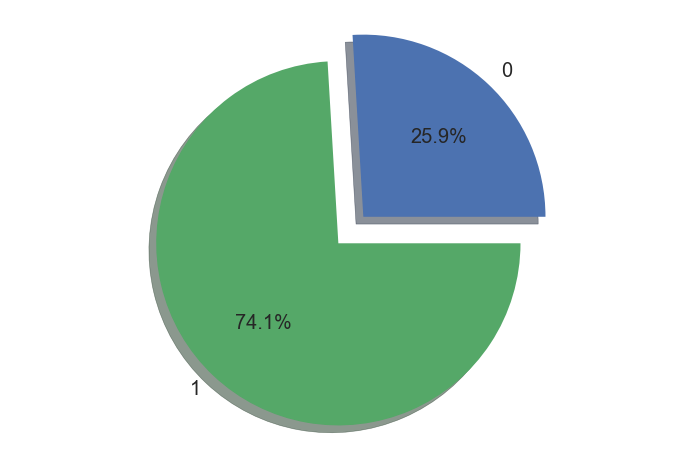

In [17]:
# Create a series to store the labels: y
y = df.case
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y)))
plot_pie(y)

### We use the vaderSentiment package to set-up a benchmark

* In order to set up benchmarks, we are going to use the polarity of the sentence calculate by the vaderSentiment package to establish the minimum at which to arrive in terms of precision and accuracy

* Since the package was made to classify three differents sentiments (negative, neutral and positive) , first we are going to understand how our data will be distributed in this three category's using the given polarity and then set the threshold to classify between just two values: negative and positive.

* References: 

*<https://github.com/cjhutto/vaderSentiment>*

*<http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html>*

In [18]:
analyser = SentimentIntensityAnalyzer()
def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))
print_sentiment_scores(df.loc[4,"message"])

NO!  You must pay for it yourself.  You were not born this way, it was your decision to change, now do NOT expect the American taxpayer to pick up the tab! {'neg': 0.145, 'neu': 0.855, 'pos': 0.0, 'compound': -0.6016}


In [19]:
df.loc[:,"sentiment_score"]=df.loc[:,"message"].apply(lambda x: analyser.polarity_scores(x).get('compound'))
df.loc[:,"sentiment_score"].head()

0    0.0000
1   -0.4983
2   -0.9393
3   -0.5882
4   -0.6016
Name: sentiment_score, dtype: float64

Información del dataset:
 las clases del target son: Counter({1: 9351, 0: 3276})


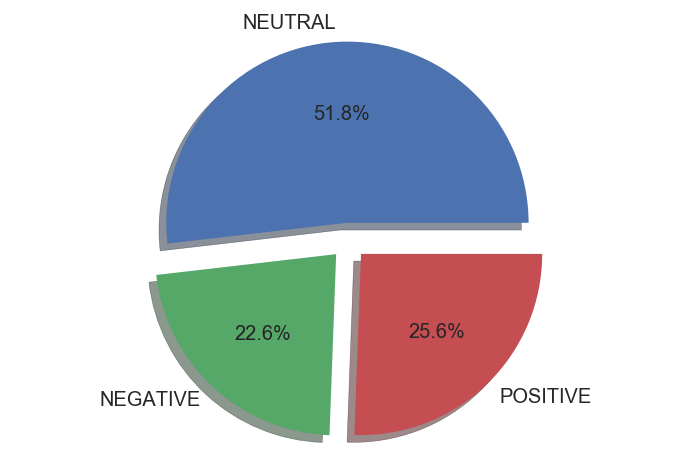

In [20]:
def assign_sentiment(x):
    if(x>=0.5):
        return "POSITIVE" 
    elif(x<=-0.5):
        return "NEGATIVE"
    else:
        return "NEUTRAL"
df.loc[:,"sentiment"]=df.loc[:,"sentiment_score"].apply(lambda x: assign_sentiment(x))
# Create a series to store the labels: y
preds=df.sentiment
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y)))
plot_pie(preds)

       count     mean       std     min     25%     50%     75%     max
case                                                                   
0     3276.0 -0.18717  0.500278 -0.9942 -0.6239 -0.1531  0.0258  0.9935
1     9351.0  0.10562  0.540865 -0.9963 -0.3412  0.0000  0.5994  0.9935


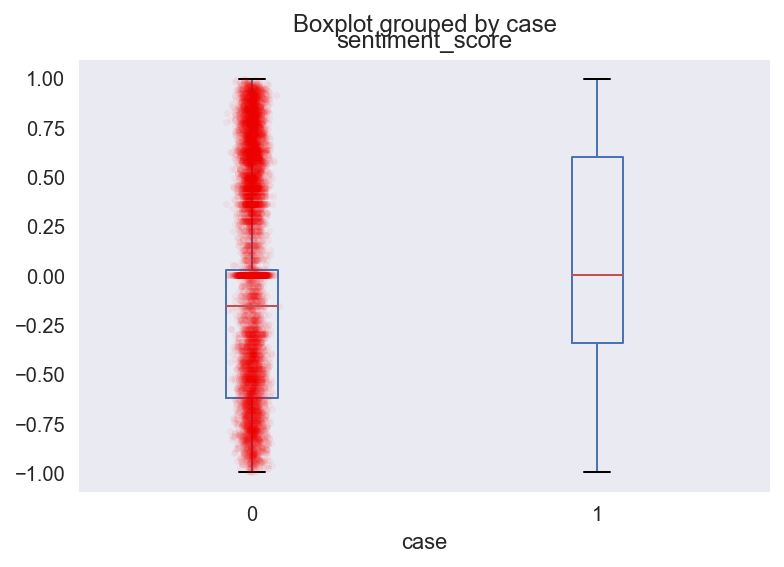

In [21]:
print(df.groupby('case')['sentiment_score'].describe())
bp = df.boxplot(column='sentiment_score',by='case',grid=False)
for i in [0,1]:
    y = df.sentiment_score[df.case==i].dropna()
    x = np.random.normal(i, 0.02, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.05)

In [22]:
pd.crosstab(df.case,df.sentiment, margins=True,normalize='columns')

sentiment,NEGATIVE,NEUTRAL,POSITIVE,All
case,,,,
0,0.396001,0.27013,0.117301,0.259444
1,0.603999,0.72987,0.882699,0.740556


#### Set the threshold to classify

* As we can see, the results indicates that the sentiment using the polarity is very accurate to classify the positive sentiment, but make a very poor performance for the negatives. Also, most of the neutral sentiments are positive's (72%)


* Using this results, the set the threshold in -0.5, so the values over it are positives and the values under it are negative


* As we expected, the precision and recall for the positive values is good (78% and 82%) but it's much poor for the negatives (only 40% and 34%) However, the accuracy is 69%, which sets the minimum threshold for our work


* Also, the accepted standar for this models is the equivalent to the understand of human between each other, which is around 70% and 90%, ussualy 80% is used *<https://www.quora.com/What-is-the-accepted-accuracy-of-sentiment-analysis>*


* So, we set the minimum threshold of 69%, so the model be acceptable, and 80% will be a good model accuracy.

In [23]:
def assign_sentiment(x):
    if(x>=-0.5):
        return 1 
    else:
        return 0
df.loc[:,"sentiment_vader"]=df.loc[:,"sentiment_score"].apply(lambda x: assign_sentiment(x))

In [24]:
preds=df.sentiment_vader
y = df.case
# Create confusion matrix
print(classification_report(y, preds))
pd.crosstab(y, preds, rownames=['Actual class'], colnames=['Predicted class'],margins=True)

             precision    recall  f1-score   support

          0       0.40      0.34      0.37      3276
          1       0.78      0.82      0.80      9351

avg / total       0.68      0.69      0.69     12627



Predicted class,0,1,All
Actual class,,,
0,1129,2147,3276
1,1721,7630,9351
All,2850,9777,12627


In [25]:
print(accuracy_score(y, preds))

0.693672289538291


#### Diccionario para la extracción, conteo y polaridad de emojis

*<https://github.com/words/emoji-emotion/blob/master/index.json>*

In [26]:
emoji_list=[
       {
        "name": "100",
        "emoji": "💯",
        "polarity": 3
       },
       {
        "name": "angry",
        "emoji": "😠",
        "polarity": -3
       },
       {
        "name": "anguished",
        "emoji": "😧",
        "polarity": -3
      },
      {
        "name": "astonished",
        "emoji": "😲",
        "polarity": 2
      },
      {
        "name": "black_heart",
        "emoji": "🖤",
        "polarity": 3
      },
      {
        "name": "blue_heart",
        "emoji": "💙",
        "polarity": 3
      },
      {
        "name": "blush",
        "emoji": "😊",
        "polarity": 2
      },
      {
        "name": "broken_heart",
        "emoji": "💔",
        "polarity": -3
      },
      {
        "name": "clap",
        "emoji": "👏",
        "polarity": 3
      },
      {
        "name": "clown_face",
        "emoji": "🤡",
        "polarity": 0
      },
      {
        "name": "cold_sweat",
        "emoji": "😰",
        "polarity": -2
      },
      {
        "name": "confounded",
        "emoji": "😖",
        "polarity": -2
      },
      {
        "name": "confused",
        "emoji": "😕",
        "polarity": -2
      },
      {
        "name": "cowboy_hat_face",
        "emoji": "🤠",
        "polarity": 2
      },
      {
        "name": "crossed_fingers",
        "emoji": "🤞",
        "polarity": 2
      },
      {
        "name": "cry",
        "emoji": "😢",
        "polarity": -2
      },
      {
        "name": "crying_cat_face",
        "emoji": "😿",
        "polarity": -2
      },
      {
        "name": "cupid",
        "emoji": "💘",
        "polarity": 3
      },
      {
        "name": "disappointed",
        "emoji": "😞",
        "polarity": -2
      },
      {
        "name": "disappointed_relieved",
        "emoji": "😥",
        "polarity": -1
      },
      {
        "name": "dizzy_face",
        "emoji": "😵",
        "polarity": -1
      },
      {
        "name": "drooling_face",
        "emoji": "🤤",
        "polarity": 0
      },
      {
        "name": "expressionless",
        "emoji": "😑",
        "polarity": 0
      },
      {
        "name": "face_with_head_bandage",
        "emoji": "🤕",
        "polarity": -2
      },
      {
        "name": "face_with_thermometer",
        "emoji": "🤒",
        "polarity": -1
      },
      {
        "name": "fearful",
        "emoji": "😨",
        "polarity": -2
      },
      {
        "name": "flushed",
        "emoji": "😳",
        "polarity": -2
      },
      {
        "name": "frowning",
        "emoji": "😦",
        "polarity": -1
      },
      {
        "name": "frowning_face",
        "emoji": "☹️",
        "polarity": -2
      },
      {
        "name": "fu",
        "emoji": "🖕",
        "polarity": -4
      },
      {
        "name": "ghost",
        "emoji": "👻",
        "polarity": -1
      },
      {
        "name": "gift_heart",
        "emoji": "💝",
        "polarity": 3
      },
      {
        "name": "green_heart",
        "emoji": "💚",
        "polarity": 3
      },
      {
        "name": "grimacing",
        "emoji": "😬",
        "polarity": -2
      },
      {
        "name": "grin",
        "emoji": "😁",
        "polarity": 2
      },
      {
        "name": "grinning",
        "emoji": "😀",
        "polarity": 2
      },
      {
        "name": "handshake",
        "emoji": "🤝",
        "polarity": 1
      },
      {
        "name": "heart",
        "emoji": "❤️",
        "polarity": 3
      },
      {
        "name": "heart_eyes",
        "emoji": "😍",
        "polarity": 3
      },
      {
        "name": "heart_eyes_cat",
        "emoji": "😻",
        "polarity": 3
      },
      {
        "name": "heartbeat",
        "emoji": "💓",
        "polarity": 3
      },
      {
        "name": "heartpulse",
        "emoji": "💗",
        "polarity": 3
      },
      {
        "name": "hugs",
        "emoji": "🤗",
        "polarity": 2
      },
      {
        "name": "hushed",
        "emoji": "😯",
        "polarity": -1
      },
      {
        "name": "imp",
        "emoji": "👿",
        "polarity": -4
      },
      {
        "name": "innocent",
        "emoji": "😇",
        "polarity": 3
      },
      {
        "name": "joy",
        "emoji": "😂",
        "polarity": 3
      },
      {
        "name": "joy_cat",
        "emoji": "😹",
        "polarity": 3
      },
      {
        "name": "kiss",
        "emoji": "💋",
        "polarity": 2
      },
      {
        "name": "kissing",
        "emoji": "😗",
        "polarity": 2
      },
      {
        "name": "kissing_cat",
        "emoji": "😽",
        "polarity": 2
      },
      {
        "name": "kissing_closed_eyes",
        "emoji": "😚",
        "polarity": 2
      },
      {
        "name": "kissing_heart",
        "emoji": "😘",
        "polarity": 3
      },
      {
        "name": "kissing_smiling_eyes",
        "emoji": "😙",
        "polarity": 2
      },
      {
        "name": "laughing",
        "emoji": "😆",
        "polarity": 1
      },
      {
        "name": "lips",
        "emoji": "👄",
        "polarity": 2
      },
      {
        "name": "lying_face",
        "emoji": "🤥",
        "polarity": -2
      },
      {
        "name": "mask",
        "emoji": "😷",
        "polarity": -1
      },
      {
        "name": "money_mouth_face",
        "emoji": "🤑",
        "polarity": 0
      },
      {
        "name": "nauseated_face",
        "emoji": "🤢",
        "polarity": -2
      },
      {
        "name": "nerd_face",
        "emoji": "🤓",
        "polarity": -1
      },
      {
        "name": "neutral_face",
        "emoji": "😐",
        "polarity": 0
      },
      {
        "name": "no_mouth",
        "emoji": "😶",
        "polarity": 0
      },
      {
        "name": "ok_hand",
        "emoji": "👌",
        "polarity": 2
      },
      {
        "name": "open_mouth",
        "emoji": "😮",
        "polarity": -2
      },
      {
        "name": "pensive",
        "emoji": "😔",
        "polarity": -1
      },
      {
        "name": "persevere",
        "emoji": "😣",
        "polarity": -2
      },
      {
        "name": "pouting_cat",
        "emoji": "😾",
        "polarity": -4
      },
      {
        "name": "pray",
        "emoji": "🙏",
        "polarity": 1
      },
      {
        "name": "punch",
        "emoji": "👊",
        "polarity": -1
      },
      {
        "name": "purple_heart",
        "emoji": "💜",
        "polarity": 3
      },
      {
        "name": "rage",
        "emoji": "😡",
        "polarity": -4
      },
      {
        "name": "raised_hands",
        "emoji": "🙌",
        "polarity": 4
      },
      {
        "name": "relaxed",
        "emoji": "☺️",
        "polarity": 2
      },
      {
        "name": "relieved",
        "emoji": "😌",
        "polarity": 2
      },
      {
        "name": "revolving_hearts",
        "emoji": "💞",
        "polarity": 3
      },
      {
        "name": "rofl",
        "emoji": "🤣",
        "polarity": 4
      },
      {
        "name": "roll_eyes",
        "emoji": "🙄",
        "polarity": -1
      },
      {
        "name": "scream",
        "emoji": "😱",
        "polarity": -3
      },
      {
        "name": "scream_cat",
        "emoji": "🙀",
        "polarity": -3
      },
      {
        "name": "shit",
        "emoji": "💩",
        "polarity": -3
      },
      {
        "name": "skull",
        "emoji": "💀",
        "polarity": -2
      },
      {
        "name": "skull_and_crossbones",
        "emoji": "☠️",
        "polarity": -2
      },
      {
        "name": "sleeping",
        "emoji": "😴",
        "polarity": 0
      },
      {
        "name": "sleepy",
        "emoji": "😪",
        "polarity": 0
      },
      {
        "name": "slightly_frowning_face",
        "emoji": "🙁",
        "polarity": -1
      },
      {
        "name": "slightly_smiling_face",
        "emoji": "🙂",
        "polarity": 1
      },
      {
        "name": "smile",
        "emoji": "😄",
        "polarity": 2
      },
      {
        "name": "smile_cat",
        "emoji": "😸",
        "polarity": 2
      },
      {
        "name": "smiley",
        "emoji": "😃",
        "polarity": 2
      },
      {
        "name": "smiley_cat",
        "emoji": "😺",
        "polarity": 2
      },
      {
        "name": "smiling_imp",
        "emoji": "😈",
        "polarity": -3
      },
      {
        "name": "smirk",
        "emoji": "😏",
        "polarity": 2
      },
      {
        "name": "smirk_cat",
        "emoji": "😼",
        "polarity": 2
      },
      {
        "name": "sneezing_face",
        "emoji": "🤧",
        "polarity": -2
      },
      {
        "name": "sob",
        "emoji": "😭",
        "polarity": -3
      },
      {
        "name": "sparkling_heart",
        "emoji": "💖",
        "polarity": 3
      },
      {
        "name": "stuck_out_tongue",
        "emoji": "😛",
        "polarity": 1
      },
      {
        "name": "stuck_out_tongue_closed_eyes",
        "emoji": "😝",
        "polarity": 0
      },
      {
        "name": "stuck_out_tongue_winking_eye",
        "emoji": "😜",
        "polarity": -1
      },
      {
        "name": "sunglasses",
        "emoji": "😎",
        "polarity": 1
      },
      {
        "name": "sweat",
        "emoji": "😓",
        "polarity": -1
      },
      {
        "name": "sweat_smile",
        "emoji": "😅",
        "polarity": 2
      },
      {
        "name": "thinking",
        "emoji": "🤔",
        "polarity": -1
      },
      {
        "name": "thumbsdown",
        "emoji": "👎",
        "polarity": -2
      },
      {
        "name": "thumbsup",
        "emoji": "👍",
        "polarity": 2
      },
      {
        "name": "tired_face",
        "emoji": "😫",
        "polarity": -2
      },
      {
        "name": "triumph",
        "emoji": "😤",
        "polarity": 0
      },
      {
        "name": "two_hearts",
        "emoji": "💕",
        "polarity": 3
      },
      {
        "name": "unamused",
        "emoji": "😒",
        "polarity": -2
      },
      {
        "name": "upside_down_face",
        "emoji": "🙃",
        "polarity": 0
      },
      {
        "name": "v",
        "emoji": "✌️",
        "polarity": 2
      },
      {
        "name": "weary",
        "emoji": "😩",
        "polarity": -2
      },
      {
        "name": "wink",
        "emoji": "😉",
        "polarity": 3
      },
      {
        "name": "worried",
        "emoji": "😟",
        "polarity": -3
      },
      {
        "name": "yellow_heart",
        "emoji": "💛",
        "polarity": 3
      },
      {
        "name": "yum",
        "emoji": "😋",
        "polarity": 3
      },
      {
        "name": "zipper_mouth_face",
        "emoji": "🤐",
        "polarity": -1
      }
]

## Pre-processing

### Extract the information from the emojis in the text

* emoji's polarity
* Númber of positive emojis
* Number of negative emojis

* References:
    *<https://stackoverflow.com/questions/43146528/how-to-extract-all-the-emojis-from-text/48376256#48376256>*

In [27]:
df.loc[:,"emojis_polarity"]=df.loc[:,"message"].apply(lambda x: extract_emojis_polarity(x).copy())
df.loc[:,"n_emojis"]=df.loc[:,"emojis_polarity"].apply(lambda x: len(x)).copy()
df.loc[:,"negative_emojis"]=df.loc[:,"emojis_polarity"].apply(lambda x: len([p for p in x if(p<0)])).copy()
df.loc[:,"positive_emojis"]=df.loc[:,"emojis_polarity"].apply(lambda x: len([p for p in x if(p>0)])).copy()
df.emojis_polarity=df.emojis_polarity.apply(lambda x: x[0] if (len(x)>0) else 0)
df[(df.emojis_polarity!=0)].shape

(335, 9)

In [28]:
df[(df.negative_emojis>0) |(df.positive_emojis>0)].shape

(335, 9)

### Clean text using regex

In [29]:
df.loc[:,"clean_message"]=df.loc[:,"message"].apply(lambda x: cleanText(x)).copy()

### Add the negation marking to the words and create the variable numbers of negations

In [30]:
negation_finder=re.compile(r"""(never|nothing|nowhere|noone|none|not|no|havent|hasnt|hadnt|cant|couldnt|shouldnt|
wont|wouldnt|dont|doesnt|didnt|isnt|arent|aint)""",flags=re.I | re.X | re.MULTILINE )
clp_finder=re.compile(r"""[,.:;!?]""",flags=re.I | re.X | re.MULTILINE )
df.loc[:,"n_negation"]=df.message.apply(lambda x: negation_finder.subn('',x)[1])

In [31]:
df.loc[:,"clean_message_neg"]=df.loc[:,"clean_message"].apply(
    lambda x: negation_marks(x,clp_finder,negation_finder) if (clp_finder.findall(x)==[]) 
    else negation_3_words_rules(x,clp_finder,negation_finder)).copy()

In [32]:
df.loc[1500,"clean_message"]

'Bunch of damn idiots, he got a drink of water, who the hell cares!!!!! I hope next time he has ice cream he gets NUMBER  scoops and all these damn fools pass the hell out, I ve never seen more idiotic people in my NUMBER  years on this earth! I m going to call and see if our President will talk to me and ask him not to eat or drink in front of those fools ever again, they might have a heart attack and some asshole will accuse him of murder!!!'

In [33]:
df.loc[1500,"clean_message_neg"]

'Bunch of damn idiots  he got a drink of water  who the hell cares      I hope next time he has ice cream he gets NUMBER scoops and all these damn fools pass the hell out  I ve never_NEG seen_NEG more_NEG idiotic_NEG people in my NUMBER years on this earth  I m going to call and see if our President will talk to me and ask him not_NEG to_NEG eat_NEG or_NEG drink in front of those fools ever again  they might have a heart attack and some asshole will accuse him of murder    '

In [34]:
df['clean_message'][4]

'NO!  You must pay for it yourself.  You were not born this way, it was your decision to change, now do NOT expect the American taxpayer to pick up the tab!'

In [35]:
df['clean_message_neg'][4]

'NO_NEG _NEG You_NEG must_NEG pay for it yourself  You were not_NEG born_NEG this_NEG way_NEG  it was your decision to change  now do NOT_NEG expect_NEG the_NEG American_NEG taxpayer to pick up the tab  '

### Create some cool features that may be useful (we will figure it out)

* For each row in the datset we will get the following numercial features:
    * Number of words with the variable name n_words
    * Number of sentences with the variable name n_sentences
    * Number of entities with the variable name n_entities
    * Number of words writen with only capitals letters with the variable name n_capitals
    * Number of exclamations (! or ¡) with the variable name n_exclamations
    * Number of ask signs (? or ¿) with the variable name n_ask_signs
    * The number of qualifier adjectives in the sentence as n_adj Example: '*mentally ill* person'
    * The number of verbs in the sentence as n_verbs

In [36]:
df.loc[:,"n_words"]=df.loc[:,"message"].apply(lambda x: len(x.split())).copy()
df.loc[:,"n_exclamations"]=df.loc[:,"message"].apply(lambda x: count_exclamations(x)).copy()
df.loc[:,"n_questions"]=df.loc[:,"message"].apply(lambda x: count_questions(x)).copy()
df.loc[:,"n_capitals"]=df.loc[:,"clean_message"].apply(lambda x: count_capital(x)).copy()
df.loc[:,"n_sentences"]=df.loc[:,"message"].apply(lambda x: count_sentences(doc=x,parser=parser)).copy()
df.loc[:,"entities"]=df.loc[:,"message"].apply(lambda x: get_entities(doc=x,parser=parser)).copy()
df.loc[:,"n_entities"]=df.loc[:,"entities"].apply(lambda x: len(x)).copy()
df.loc[:,"n_adj"]=df.loc[:,"clean_message"].apply(lambda x: n_adj(doc=x,parser=parser)).copy()
df.loc[:,"n_verbs"]=df.loc[:,"clean_message"].apply(lambda x: n_verbs(doc=x,parser=parser)).copy()
df.loc[:,"n_mentions"]=df.loc[:,"clean_message"].apply(lambda x: count_mentions(x)).copy()
df.loc[:,"n_hashtag"]=df.loc[:,"clean_message"].apply(lambda x: count_hashtag(x)).copy()

In [37]:
df.to_csv('df_v2_pos_negation_mark.csv',encoding='utf-8',sep=';',index=False)
backup=df

In [38]:
df.head()

,case,message,sentiment_score,sentiment,sentiment_vader,emojis_polarity,n_emojis,negative_emojis,positive_emojis,clean_message,...,n_exclamations,n_questions,n_capitals,n_sentences,entities,n_entities,n_adj,n_verbs,n_mentions,n_hashtag
0,0,She/he was elected because???,0.0000,NEUTRAL,1,0,0,0,0,Shehe was elected because???,...,0,3,0,1,[],0,0,2,0,0
1,0,That a elective surgery. So NO,-0.4983,NEUTRAL,1,0,0,0,0,That a elective surgery. So NO,...,0,0,1,2,[],0,1,0,0,0
2,1,Danica roem is a mentally ill freak. this sick...,-0.9393,NEGATIVE,0,0,0,0,0,Danica roem is a mentally ill freak. this sick...,...,0,0,0,3,[],0,5,9,0,0
3,0,I would gladly paid for psiquiatric treatment....,-0.5882,NEGATIVE,0,0,0,0,0,I would gladly paid for psiquiatric treatment....,...,1,0,1,2,[],0,3,4,0,0
4,0,NO! You must pay for it yourself. You were n...,-0.6016,NEGATIVE,0,0,0,0,0,NO! You must pay for it yourself. You were n...,...,2,0,2,3,[],0,1,9,0,0


#### Scale the numeric data

* In order to understand the relations between the numeric data and with the target, we are going to normalize the data. Since all the variables has a lot of outliers and we are working in a text minning problem, the recommended way to do it it's use Normalize. *<http://scikit-learn.org/stable/modules/preprocessing.html>*

**Reference:**
* "This assumption is the base of the Vector Space Model often used in text classification and clustering contexts."

* *<http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization>*

* *<https://stackoverflow.com/questions/21030391/how-to-normalize-an-array-in-numpy>*

#### Give the normalized  data to the data frame

In [39]:
features=["n_exclamations","n_capitals","n_adj","n_verbs","n_questions",'n_emojis','negative_emojis','n_negation',
          'positive_emojis','n_sentences','n_words','emojis_polarity','n_entities','n_mentions','n_hashtag']
#minmaxscaler=MinMaxScaler()
#X_std=minmaxscaler.fit_transform(df[features])
X_std=normalize(df[features],axis=0,norm='l2')
numerical_features=pd.DataFrame(data=X_std,columns=features)
numerical_features.loc[:,'emojis_polarity']=1+numerical_features.emojis_polarity

In [40]:
df[features].tail(3)

,n_exclamations,n_capitals,n_adj,n_verbs,n_questions,n_emojis,negative_emojis,n_negation,positive_emojis,n_sentences,n_words,emojis_polarity,n_entities,n_mentions,n_hashtag
12624,0,1,4,7,0,0,0,2,0,3,31,0,1,0,0
12625,0,0,1,6,0,0,0,0,0,1,18,0,0,0,0
12626,1,0,1,6,0,0,0,0,0,2,16,0,0,0,0


In [41]:
numerical_features.tail(3)

,n_exclamations,n_capitals,n_adj,n_verbs,n_questions,n_emojis,negative_emojis,n_negation,positive_emojis,n_sentences,n_words,emojis_polarity,n_entities,n_mentions,n_hashtag
12624,0.00000,0.0018,0.015094,0.008544,0.0,0.0,0.0,0.015639,0.0,0.008464,0.008606,1.0,0.003045,0.0,0.0
12625,0.00000,0.0000,0.003773,0.007323,0.0,0.0,0.0,0.000000,0.0,0.002821,0.004997,1.0,0.000000,0.0,0.0
12626,0.00375,0.0000,0.003773,0.007323,0.0,0.0,0.0,0.000000,0.0,0.005643,0.004442,1.0,0.000000,0.0,0.0


In [42]:
numerical_features.corr()

,n_exclamations,n_capitals,n_adj,n_verbs,n_questions,n_emojis,negative_emojis,n_negation,positive_emojis,n_sentences,n_words,emojis_polarity,n_entities,n_mentions,n_hashtag
n_exclamations,1.000000,0.208403,0.061343,0.077197,0.047534,0.020201,0.014504,0.061017,0.010995,0.181841,0.096627,-0.008389,0.104198,NaN,NaN
n_capitals,0.208403,1.000000,0.159548,0.257839,0.070897,0.002879,0.002497,0.248153,0.000990,0.450557,0.304723,-0.002390,0.334957,NaN,NaN
n_adj,0.061343,0.159548,1.000000,0.727123,0.112907,-0.003481,-0.000721,0.532329,-0.004306,0.661177,0.811640,0.000494,0.543010,NaN,NaN
n_verbs,0.077197,0.257839,0.727123,1.000000,0.148416,-0.024647,-0.011479,0.642573,-0.022460,0.777251,0.952441,-0.003627,0.631893,NaN,NaN
n_questions,0.047534,0.070897,0.112907,0.148416,1.000000,0.005519,0.020119,0.099447,-0.012373,0.191154,0.153251,-0.021098,0.104269,NaN,NaN
n_emojis,0.020201,0.002879,-0.003481,-0.024647,0.005519,1.000000,0.646286,-0.005084,0.736595,0.042750,-0.014689,0.024806,0.005253,NaN,NaN
negative_emojis,0.014504,0.002497,-0.000721,-0.011479,0.020119,0.646286,1.000000,0.003381,-0.013332,0.011812,-0.006757,-0.684227,-0.005606,NaN,NaN
n_negation,0.061017,0.248153,0.532329,0.642573,0.099447,-0.005084,0.003381,1.000000,-0.011548,0.610816,0.680251,-0.009351,0.557441,NaN,NaN
positive_emojis,0.010995,0.000990,-0.004306,-0.022460,-0.012373,0.736595,-0.013332,-0.011548,1.000000,0.046661,-0.013350,0.635696,0.009963,NaN,NaN
n_sentences,0.181841,0.450557,0.661177,0.777251,0.191154,0.042750,0.011812,0.610816,0.046661,1.000000,0.828182,0.027855,0.718986,NaN,NaN


,features,m-score,m-weight,ranking_ffe_rf,ranking_ffe_rl,ranking_ffe_gb,coef_svc,ranking_svc
13,n_words,0.000000,0.000000,1,13,1,0.000855,10
7,n_questions,0.002524,0.266629,3,2,2,0.082293,2
2,n_verbs,0.005507,0.581745,2,8,3,0.011244,6
1,emojis_polarity,0.005552,0.586570,4,1,4,0.158820,1
11,n_capitals,0.000000,0.000000,5,9,5,0.006469,7
14,n_entities,0.000000,0.000000,6,6,6,0.024015,5
0,n_negation,0.009466,1.000000,9,5,7,0.042454,3
8,n_sentences,0.002260,0.238781,8,7,8,0.027257,4
9,n_exclamations,0.001837,0.194053,10,11,9,0.004762,8
12,n_adj,0.000000,0.000000,7,12,10,0.003939,9


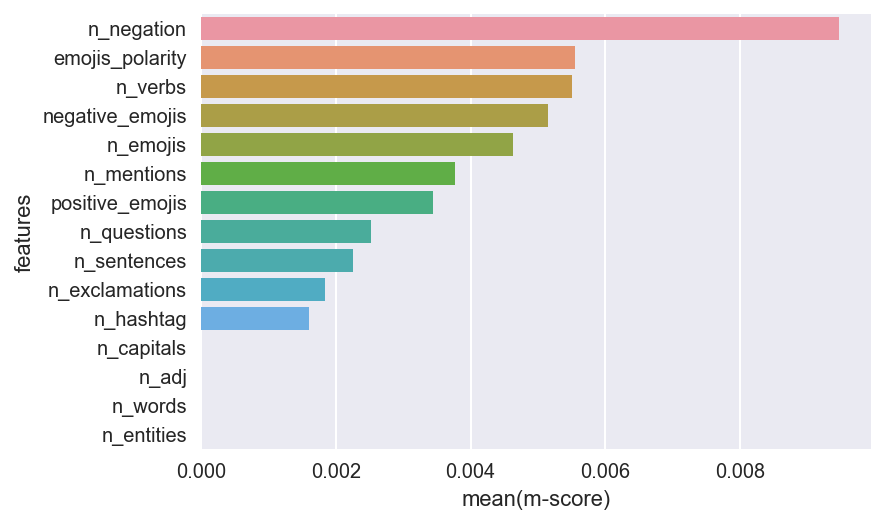

In [43]:
y=df.case
X_features_count=df[features]
selected_features=variable_selection(X_features_count,y)
sns.barplot(x='m-score', y='features', data=selected_features);
selected_features.sort_values(by='ranking_ffe_gb',ascending=True)

,features,m-score,m-weight,ranking_ffe_rf,ranking_ffe_rl,ranking_ffe_gb,coef_svc,ranking_svc
13,n_words,0.000000,0.000000,1,7,1,0.000000,12
7,n_questions,0.002524,0.268200,3,1,2,0.000000,6
2,n_verbs,0.005441,0.578159,2,6,3,0.000000,5
1,emojis_polarity,0.007448,0.791483,4,3,4,0.477816,1
11,n_capitals,0.000000,0.000000,5,8,5,0.000000,3
14,n_entities,0.000000,0.000000,6,9,6,0.000000,13
0,n_negation,0.009410,1.000000,9,4,7,0.000000,9
8,n_sentences,0.001877,0.199482,8,13,8,0.000000,11
9,n_exclamations,0.001817,0.193092,10,10,9,0.000000,2
12,n_adj,0.000000,0.000000,7,12,10,0.000000,4


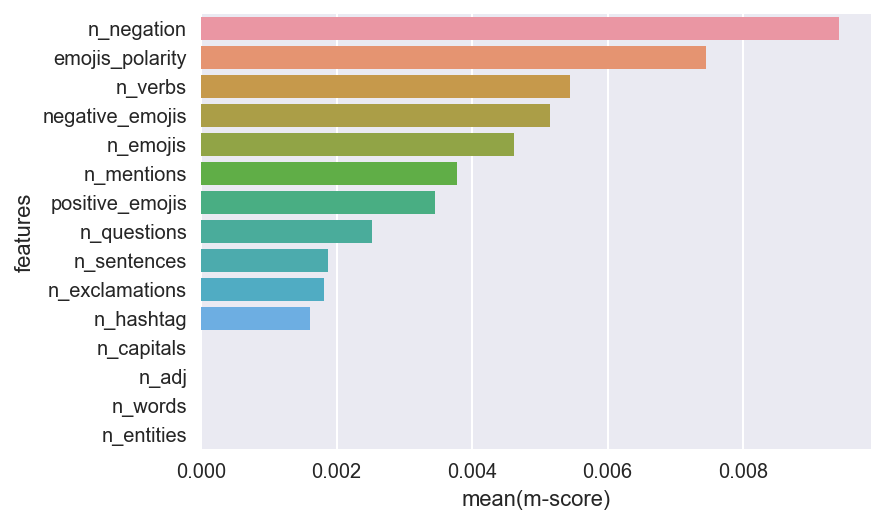

In [44]:
y=df.case
X_features_norm=numerical_features
selected_features=variable_selection(X_features_norm,y)
sns.barplot(x='m-score', y='features', data=selected_features);
selected_features.sort_values(by='ranking_ffe_gb',ascending=True)

### Conclusions of the feature selection for the numeric values

* Base in the analysis of all the graphics and test that we have made, the mutual information score's and results of the RFE selection with GB:
    
    * We leave out all the emojis features except for one, the number of emojis , because they constantly appear 
    between the least significance variables. We use emojis polarity instead because appears to be the most relevant feature of the related with the emojis
    
    * Even when we expect that number of exclamations will be relevant, we leave them out because their are in the bottom of the table for the MI and trees rankings

** emotion weight is calculate as the sum of positive weight and negative weight**
** positive weight is the relative (because the denominator is the maximum number of appearances) percentage of times that the word_pos appear in a positive sentence**
** negative weight is the relative (because the denominator is the maximum number of appearances) percentage of times that the word_pos appear in a negative sentence**

In [45]:
selected_features=['n_words','n_questions','n_verbs','n_capitals','n_entities','n_sentences','emojis_polarity',
                   'n_negation','n_adj']

### Create the vectors to train the model

Información del dataset:
 las clases del target son: Counter({1: 9351, 0: 3276})


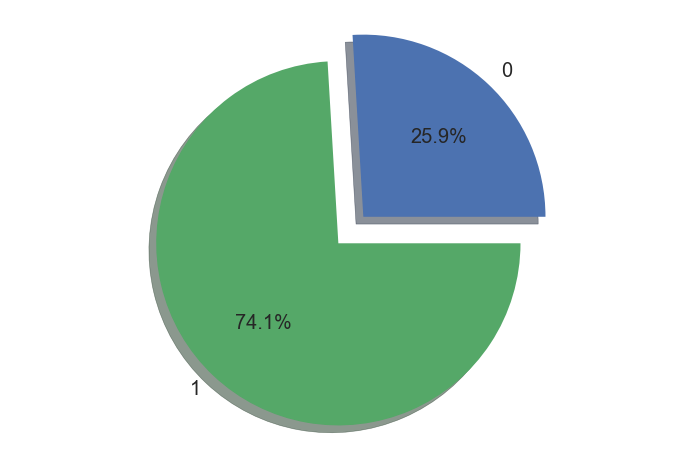

In [46]:
# Create a series to store the labels: y
y = df.case.ravel()
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y)))
plot_pie(y)

Información del dataset:
 las clases del target son: Counter({1: 7004, 0: 2466})


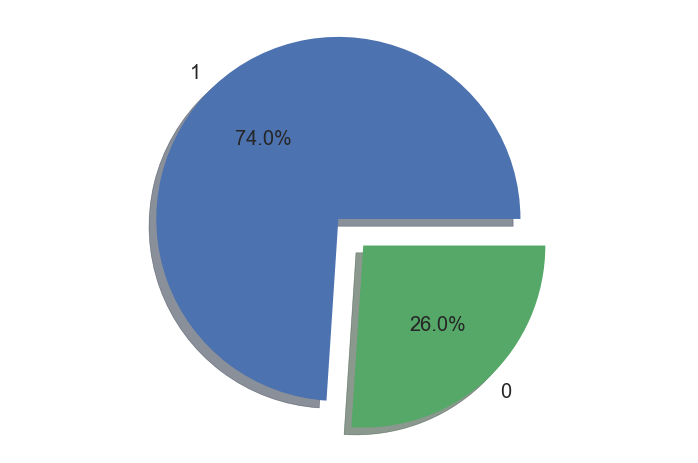

In [47]:
# Print the head of df
X=df.iloc[:,range(1,df.shape[1])]
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0,test_size=0.25)
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train)))
plot_pie(y_train)

In [48]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [49]:
# the vectorizer and classifer to use
# note that I changed the tokenizer in CountVectorizer to use a custom function using spaCy's tokenizer

# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(
    tokenizer=LemmaTokenizer(),stop_words='english',lowercase=True,token_pattern="[^A-Za-z0-9]",
    strip_accents = 'unicode',min_df=10,ngram_range=(1,2))

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train.clean_message_neg)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test.clean_message_neg)

# Print the first 10 features of the count_vectorizer
print(count_vectorizer.get_feature_names()[0:30])
# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer_spacy = CountVectorizer(
    tokenizer=spacy_tokenizer,stop_words='english',lowercase=True,min_df=10,ngram_range=(1,2))

# Transform the training data using only the 'text' column values: count_train 
count_train_spacy = count_vectorizer_spacy.fit_transform(X_train.clean_message_neg)

# Transform the test data using only the 'text' column values: count_test 
count_test_spacy = count_vectorizer_spacy.transform(X_test.clean_message_neg)

['_neg', '_neg _neg', '_neg he_neg', '_neg i_neg', '_neg it_neg', '_neg no_neg', '_neg not_neg', '_neg s', '_neg we_neg', '_neg you_neg', 'a_neg', 'abc', 'able', 'abortion', 'about_neg', 'absolutely', 'abused', 'accept', 'accountable', 'accusation', 'act', 'act like', 'acting', 'action', 'actor', 'actually', 'add', 'administration', 'admit', 'adult']


In [50]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=LemmaTokenizer(),stop_words='english',lowercase=True,token_pattern="[^A-Za-z0-9]",
    strip_accents = 'unicode',min_df=10,ngram_range=(1,2))

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train.clean_message_neg)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test.clean_message_neg)

# Initialize a TfidfVectorizer object with the spacy tokenization: tfidf_vectorizer_spacy
tfidf_vectorizer_spacy = TfidfVectorizer(
    tokenizer=spacy_tokenizer,stop_words='english',lowercase=True,token_pattern="[^A-Za-z0-9]*",
    strip_accents = 'unicode',min_df=10,ngram_range=(1,2))

# Transform the training data: tfidf_train 
tfidf_train_spacy = tfidf_vectorizer_spacy.fit_transform(X_train.clean_message_neg)

# Transform the test data: tfidf_test 
tfidf_test_spacy = tfidf_vectorizer_spacy.transform(X_test.clean_message_neg)

#### Add the numerical features to the array

*<https://stackoverflow.com/questions/8486294/how-to-add-an-extra-column-to-an-numpy-array>*

*<http://zablo.net/blog/post/twitter-sentiment-analysis-python-scikit-word2vec-nltk-xgboost>*

In [51]:
def add_features(vectorizer,X,vector_train,selected_features):
    n=len(selected_features)
    i=len(vector_train.toarray())
    j=len(vector_train.toarray()[0])
    a=vector_train.toarray()
    b = np.zeros((i,j+n))
    b[:,:-n] = a
    features_values=[X.loc[:,feature] for feature in selected_features]
    for i in range(n):
        b[:,j+i]=features_values[i]
    column_names=vectorizer.get_feature_names()
    [column_names.append(selected_features[i]) for i in range(n)]
    
    return [b,column_names]

def add_column_names(vectorizer,selected_features):
    n=len(selected_features)
    column_names=vectorizer.get_feature_names()
    [column_names.append(selected_features[i]) for i in range(n)]
    return column_names

In [52]:
count_features_train,col_names_count_features_train=add_features(
    vectorizer=count_vectorizer,X=X_train,vector_train=count_train,selected_features=selected_features)

count_features_test,col_names_count_features_test=add_features(
    vectorizer=count_vectorizer,X=X_test,vector_train=count_test,selected_features=selected_features)

count_features_spacy_train,col_names_count_spacy_features_train=add_features(
    vectorizer=count_vectorizer_spacy,X=X_train,vector_train=count_train_spacy,selected_features=selected_features)

count_features_spacy_test,col_names_count_spacy_features_test=add_features(
    vectorizer=count_vectorizer_spacy,X=X_test,vector_train=count_test_spacy,selected_features=selected_features)

tfidf_features_train,col_names_tfidf_features_train=add_features(
    vectorizer=tfidf_vectorizer,X=numerical_features.loc[X_train.index,selected_features],vector_train=tfidf_train,selected_features=selected_features)

tfidf_features_test,col_names_tfidf_features_test=add_features(
    vectorizer=tfidf_vectorizer,X=numerical_features.loc[X_test.index,selected_features],vector_train=tfidf_test,selected_features=selected_features)

In [53]:
# Create the CountVectorizer DataFrame: count_df
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

# Calculate the difference in columns: difference
difference = set(tfidf_df.columns) - set(count_df.columns)

# Create the CountVectorizer DataFrame: count_df
count_features_train_df = pd.DataFrame(count_features_train, columns=col_names_count_features_train)

# Create the CountVectorizerSpacy DataFrame: count_df
count_features_spacy_train_df = pd.DataFrame(count_features_spacy_train, columns=col_names_count_spacy_features_train)

# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_features_train_df = pd.DataFrame(tfidf_features_train, columns=col_names_tfidf_features_train)

# Calculate the difference in columns: difference
difference = set(tfidf_features_train_df.columns) - set(count_features_train_df.columns)

### Create all the trainning datasets which we are going to use

Información del dataset:
 las clases del target son: Counter({0: 2466, 1: 2466})


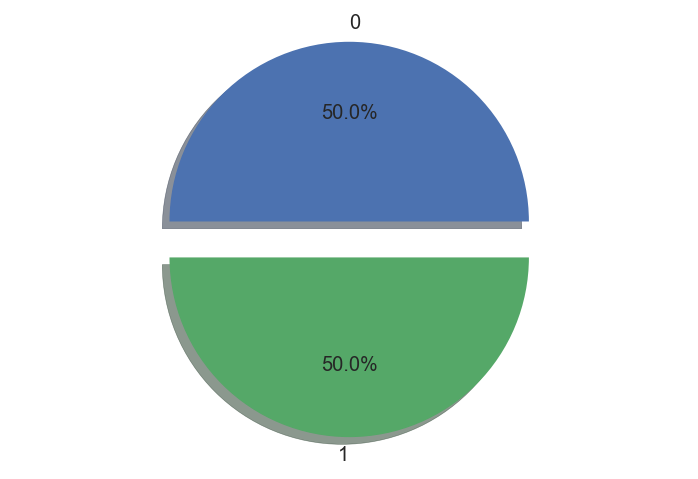

In [54]:
count_train_us, y_train_count_us , index_us= RandomUnderSampler(ratio='not minority', 
                                                      random_state=0,
                                                      return_indices=True).fit_sample(count_train,y_train)
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train_count_us)))
plot_pie(y_train_count_us)

Información del dataset:
 las clases del target son: Counter({0: 2466, 1: 2466})


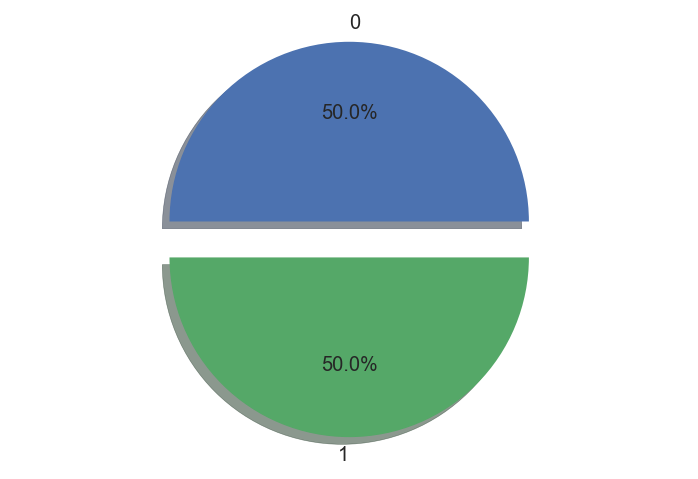

In [55]:
tfidf_train_us, y_train_tfidf_us , index_us= RandomUnderSampler(ratio='not minority', 
                                                      random_state=0,
                                                      return_indices=True).fit_sample(tfidf_train,y_train)
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train_tfidf_us)))
plot_pie(y_train_tfidf_us)

Información del dataset:
 las clases del target son: Counter({0: 2466, 1: 2466})


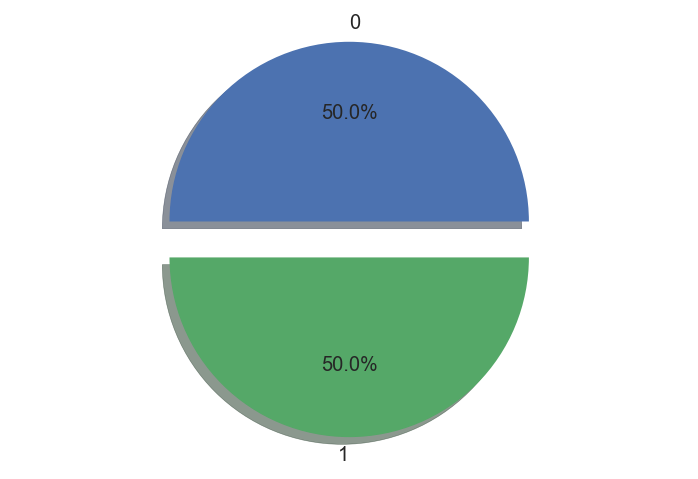

In [56]:
count_features_train_us, y_train_count_feature_us , index_us= RandomUnderSampler(ratio='not minority', 
                                                      random_state=0,
                                                      return_indices=True).fit_sample(count_features_train,y_train)
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train_count_feature_us)))
plot_pie(y_train_count_feature_us)

Información del dataset:
 las clases del target son: Counter({0: 2466, 1: 2466})


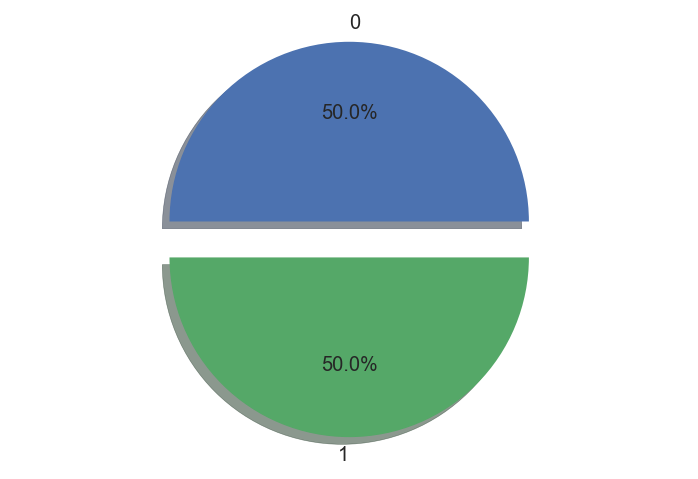

In [57]:
tfidf_features_train_us, y_train_tfidf_feature_us , index_us= RandomUnderSampler(
    ratio='not minority',random_state=0,return_indices=True).fit_sample(tfidf_features_train,y_train)
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train_tfidf_feature_us)))
plot_pie(y_train_tfidf_feature_us)

## Training

#### Find the best parameters using GridsearchCV

* To find the best parameters we are going to use only the maximium accuracy as benchmark

** References: **
*<http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html>*

In [58]:
scores={'accuracy': make_scorer(accuracy_score)}

In [59]:
algorithms=create_classifiers()
parameters=create_parameters()
clf=[]
for i in range(0,len(algorithms)):
    clf.append(GridSearchCV(estimator=algorithms[i], param_grid=parameters[i],cv=10,scoring=scores,refit='accuracy')) 

In [60]:
best_parameters_count=get_best_param(X_train=count_train,y_train=y_train,classifiers=clf);

In [61]:
best_parameters_count_spacy=get_best_param(X_train=count_train_spacy,y_train=y_train,classifiers=clf);

In [62]:
best_parameters_tfidf=get_best_param(X_train=tfidf_train,y_train=y_train,classifiers=clf);

In [63]:
best_parameters_tfidf_spacy=get_best_param(X_train=tfidf_train_spacy,y_train=y_train,classifiers=clf);

**References:** 

* Functions to model: *<http://zablo.net/blog/post/twitter-sentiment-analysis-python-scikit-word2vec-nltk-xgboost>*
* Got a lot of code and ideas from here: *<https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy>*
* The idea to include de Pasive Aggresive Classifier was from here: *<https://www.datacamp.com/community/tutorials/scikit-learn-fake-news>*

In [64]:
scores={'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall':make_scorer(recall_score),
        'F1':make_scorer(f1_score),
        #'roc-auc-score':make_scorer(roc_auc_score),
        'average-precision':'average_precision'
       }

In [65]:
algorithms=restart_classifiers(best_parameters_count)
results_count, predictions_count=train_classifier(
    X_train=count_train,y_train=y_train,X_test=count_test,models=algorithms,scoring=scores)
results_count.sort_values(by = ['Test Accuracy Mean','Test F1'], ascending = False, inplace = True)
results_count

,Algorithm,Test average-precision,Test Accuracy Mean,Test Accuracy 3*STD,Test F1,Test Recall,Parameters,Time
0,LogisticRegression,0.868463,0.741813,0.0243807,0.847706,0.971587,"{'C': 0.1, 'class_weight': None, 'dual': False...",0.050991
1,RandomForestClassifier,0.849884,0.739599,0.000929049,0.85031,1,"{'bootstrap': True, 'class_weight': None, 'cri...",1.2292
6,GradientBoostingClassifier,0.852535,0.739493,0.00104192,0.85024,0.999857,"{'criterion': 'friedman_mse', 'init': None, 'l...",1.2256
5,SVC,0.758131,0.739388,0.0010521,0.850134,0.999429,"{'C': 0.01, 'cache_size': 200, 'class_weight':...",1.2949
4,LinearSVC,0.85011,0.732098,0.0333023,0.834334,0.912194,"{'C': 0.1, 'class_weight': None, 'dual': True,...",0.0811486
3,MultinomialNB,0.868873,0.722381,0.033404,0.81816,0.844512,"{'alpha': 0.5, 'class_prior': [0.259, 0.741], ...",0.00400693
2,BernoulliNB,0.864125,0.716571,0.0329311,0.815124,0.845082,"{'alpha': 0.001, 'binarize': 0, 'class_prior':...",0.00509646


In [66]:
algorithms=restart_classifiers(best_parameters_count_spacy)
results_count_spacy, predictions_count_spacy=train_classifier(
    X_train=count_train_spacy,y_train=y_train,X_test=count_test_spacy,models=algorithms,scoring=scores)
results_count_spacy.sort_values(by = ['Test Accuracy Mean','Test F1'], ascending = False, inplace = True)
results_count_spacy

,Algorithm,Test average-precision,Test Accuracy Mean,Test Accuracy 3*STD,Test F1,Test Recall,Parameters,Time
0,LogisticRegression,0.860128,0.739915,0.00670099,0.849788,0.994718,"{'C': 0.01, 'class_weight': None, 'dual': Fals...",0.0724615
1,RandomForestClassifier,0.85298,0.739599,0.000929049,0.85031,1,"{'bootstrap': True, 'class_weight': None, 'cri...",1.34793
6,GradientBoostingClassifier,0.858929,0.739599,0.000929049,0.85031,1,"{'criterion': 'friedman_mse', 'init': None, 'l...",1.04629
5,SVC,0.78625,0.73886,0.00534212,0.849711,0.998145,"{'C': 0.01, 'cache_size': 200, 'class_weight':...",2.37869
4,LinearSVC,0.841803,0.735269,0.0129302,0.841648,0.951313,"{'C': 0.1, 'class_weight': None, 'dual': True,...",0.188006
3,MultinomialNB,0.869967,0.701581,0.0464365,0.796815,0.791259,"{'alpha': 1, 'class_prior': [0.259, 0.741], 'f...",0.00913002
2,BernoulliNB,0.861657,0.697139,0.0486302,0.79898,0.813816,"{'alpha': 0.001, 'binarize': 0, 'class_prior':...",0.00778511


In [67]:
algorithms=restart_classifiers(best_parameters_tfidf)
results_tfidf, predictions_tfidf=train_classifier(
    X_train=tfidf_train,y_train=y_train,X_test=tfidf_test,models=algorithms,scoring=scores)
results_tfidf.sort_values(by = ['Test Accuracy Mean','Test F1'], ascending = False, inplace = True)
results_tfidf

,Algorithm,Test average-precision,Test Accuracy Mean,Test Accuracy 3*STD,Test F1,Test Recall,Parameters,Time
3,MultinomialNB,0.876538,0.744773,0.0335737,0.846224,0.9496,"{'alpha': 0.1, 'class_prior': [0.259, 0.741], ...",0.00580497
0,LogisticRegression,0.87692,0.744457,0.0185434,0.847491,0.960024,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.0270734
1,RandomForestClassifier,0.849122,0.739599,0.000929049,0.85031,1,"{'bootstrap': True, 'class_weight': None, 'cri...",1.27945
6,GradientBoostingClassifier,0.849622,0.739599,0.000929049,0.85031,1,"{'criterion': 'friedman_mse', 'init': None, 'l...",1.11337
2,BernoulliNB,0.864125,0.716571,0.0329311,0.815124,0.845082,"{'alpha': 0.001, 'binarize': 0, 'class_prior':...",0.00616288
4,LinearSVC,0.846344,0.71404,0.0261787,0.815217,0.852796,"{'C': 10, 'class_weight': None, 'dual': True, ...",0.203241
5,SVC,0.780554,0.693758,0.0892015,0.808753,0.881044,"{'C': 0.5, 'cache_size': 200, 'class_weight': ...",1.48134


In [68]:
algorithms=restart_classifiers(best_parameters_tfidf_spacy)
results_tfidf_spacy, predictions_tfidf_spacy=train_classifier(
    X_train=tfidf_train_spacy,y_train=y_train,X_test=tfidf_test_spacy,models=algorithms,scoring=scores)
results_tfidf_spacy.sort_values(by = ['Test Accuracy Mean','Test F1'], ascending = False, inplace = True)
results_tfidf_spacy

,Algorithm,Test average-precision,Test Accuracy Mean,Test Accuracy 3*STD,Test F1,Test Recall,Parameters,Time
0,LogisticRegression,0.879456,0.746356,0.0166432,0.849513,0.968017,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.0488044
3,MultinomialNB,0.882591,0.744981,0.0220646,0.84817,0.963162,"{'alpha': 0.5, 'class_prior': [0.259, 0.741], ...",0.00591614
1,RandomForestClassifier,0.854575,0.739599,0.000929049,0.85031,1,"{'bootstrap': True, 'class_weight': None, 'cri...",1.55554
6,GradientBoostingClassifier,0.858084,0.739599,0.000929049,0.85031,1,"{'criterion': 'friedman_mse', 'init': None, 'l...",1.29673
2,BernoulliNB,0.861657,0.697139,0.0486302,0.79898,0.813816,"{'alpha': 0.001, 'binarize': 0, 'class_prior':...",0.00690589
4,LinearSVC,0.837384,0.682367,0.0352312,0.785632,0.787122,"{'C': 10, 'class_weight': None, 'dual': True, ...",0.345515
5,SVC,0.80473,0.680773,0.0891919,0.793611,0.834945,"{'C': 0.1, 'cache_size': 200, 'class_weight': ...",3.82005


In [69]:
algorithms=restart_classifiers(best_parameters_count)
results_count_us, predictions_count_us=train_classifier(
    X_train=count_train_us,y_train=y_train_count_us,X_test=count_test,models=algorithms,scoring=scores)
results_count_us.sort_values(by = ['Test Accuracy Mean','Test F1'], ascending = False, inplace = True)
results_count_us

,Algorithm,Test average-precision,Test Accuracy Mean,Test Accuracy 3*STD,Test F1,Test Recall,Parameters,Time
0,LogisticRegression,0.69963,0.644567,0.0567431,0.637411,0.624502,"{'C': 0.1, 'class_weight': None, 'dual': False...",0.0200797
4,LinearSVC,0.675862,0.636864,0.0580387,0.632265,0.624515,"{'C': 0.1, 'class_weight': None, 'dual': True,...",0.0305617
6,GradientBoostingClassifier,0.682963,0.618224,0.0484838,0.484172,0.359317,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.633936
3,MultinomialNB,0.702966,0.607668,0.0514869,0.66765,0.788332,"{'alpha': 0.5, 'class_prior': [0.259, 0.741], ...",0.00393906
2,BernoulliNB,0.693014,0.596718,0.0554173,0.660456,0.78468,"{'alpha': 0.001, 'binarize': 0, 'class_prior':...",0.00619075
1,RandomForestClassifier,0.646023,0.581335,0.0697411,0.449764,0.343945,"{'bootstrap': True, 'class_weight': None, 'cri...",0.910072
5,SVC,0.54744,0.500202,0.00182186,0.666666,0.999593,"{'C': 0.01, 'cache_size': 200, 'class_weight':...",0.649424


In [70]:
algorithms=restart_classifiers(best_parameters_tfidf)
results_tfidf_us, predictions_tfidf_us=train_classifier(
    X_train=tfidf_train_us,y_train=y_train_tfidf_us,X_test=tfidf_test,models=algorithms,scoring=scores)
results_tfidf_us.sort_values(by = ['Test Accuracy Mean','Test F1'], ascending = False, inplace = True)
results_tfidf_us

,Algorithm,Test average-precision,Test Accuracy Mean,Test Accuracy 3*STD,Test F1,Test Recall,Parameters,Time
0,LogisticRegression,0.722332,0.648822,0.0587174,0.63641,0.614364,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.0120867
4,LinearSVC,0.667314,0.6249,0.0439294,0.624163,0.623288,"{'C': 10, 'class_weight': None, 'dual': True, ...",0.121842
6,GradientBoostingClassifier,0.684462,0.621476,0.0607278,0.503648,0.384867,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.678631
2,BernoulliNB,0.693014,0.596718,0.0554173,0.660456,0.78468,"{'alpha': 0.001, 'binarize': 0, 'class_prior':...",0.00418975
1,RandomForestClassifier,0.644371,0.576875,0.0668452,0.458992,0.359327,"{'bootstrap': True, 'class_weight': None, 'cri...",1.0989
3,MultinomialNB,0.719532,0.571373,0.0412569,0.678653,0.90511,"{'alpha': 0.1, 'class_prior': [0.259, 0.741], ...",0.00304246
5,SVC,0.574797,0.531027,0.0709919,0.624225,0.784764,"{'C': 0.5, 'cache_size': 200, 'class_weight': ...",0.790673


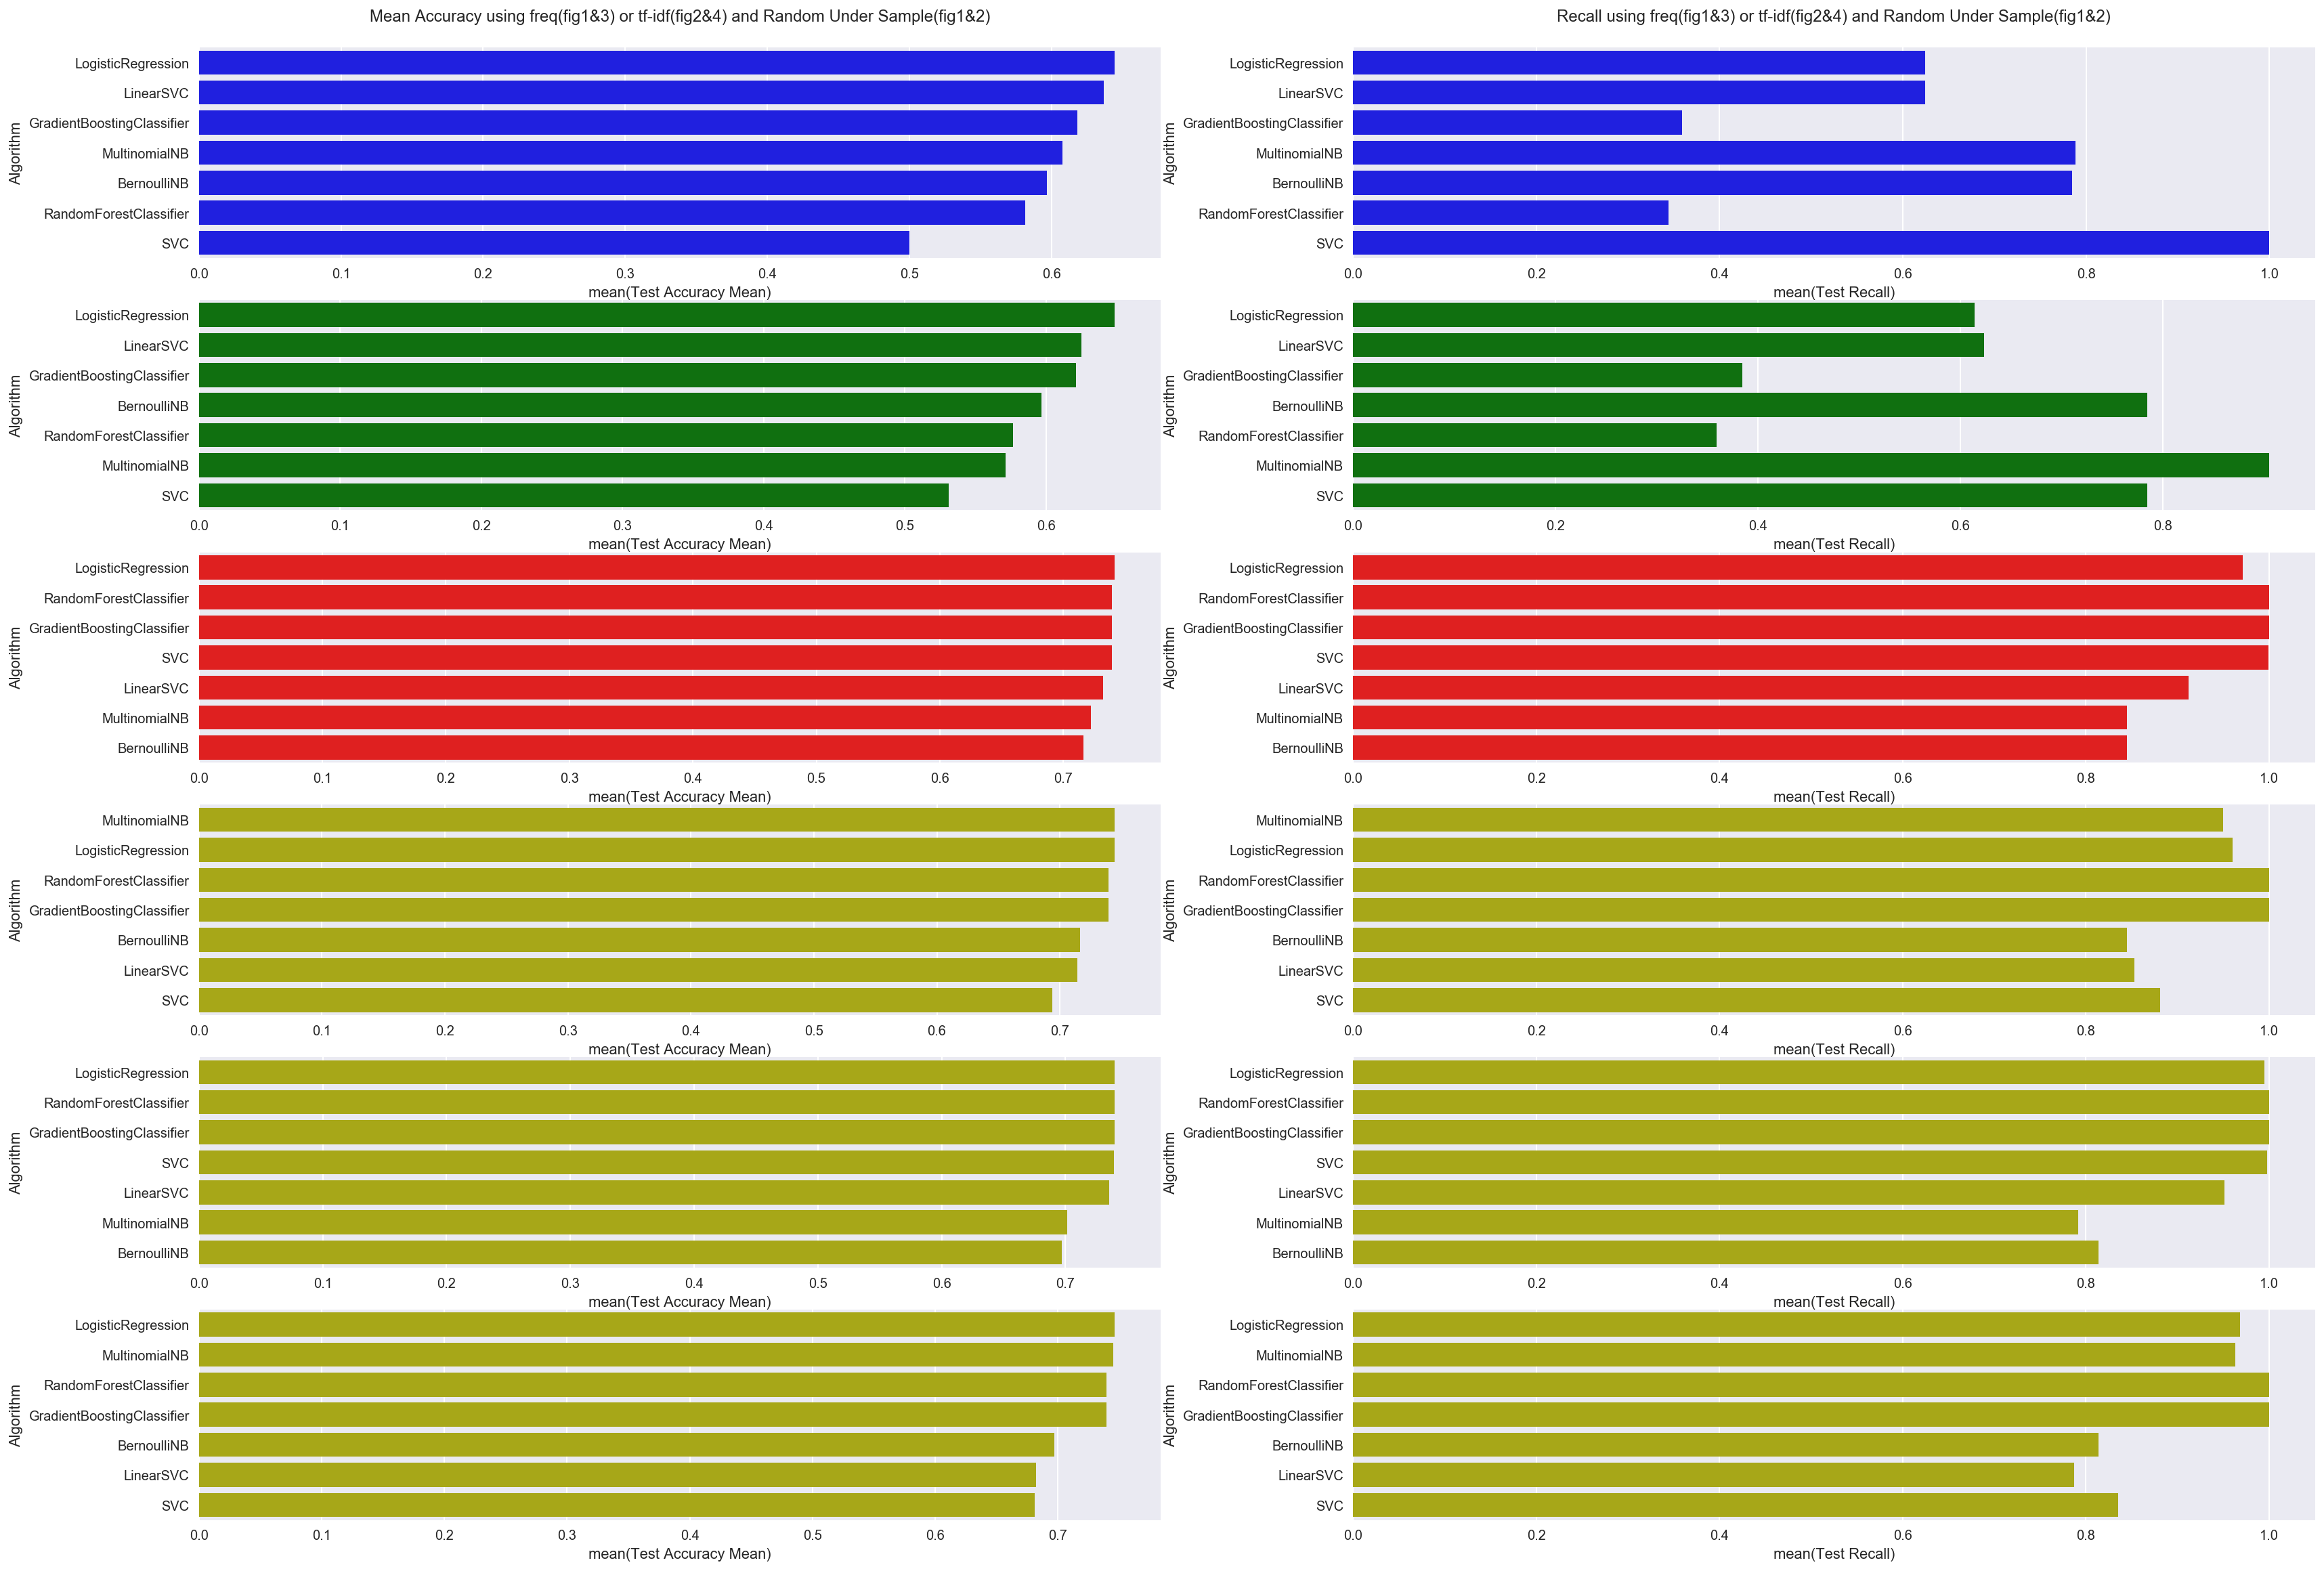

In [71]:
#more side-by-side comparisons
fig, axis = plt.subplots(6, 2,figsize=(28,20))

axis[0,0].set_title('Mean Accuracy using freq(fig1&3) or tf-idf(fig2&4) and Random Under Sample(fig1&2)\n')
sns.barplot(x='Test Accuracy Mean', y = 'Algorithm', data = results_count_us, color = 'b',ax = axis[0,0])
sns.barplot(x='Test Recall', y = 'Algorithm', data = results_count_us, color = 'b',ax = axis[0,1])
axis[0,1].set_title('Recall using freq(fig1&3) or tf-idf(fig2&4) and Random Under Sample(fig1&2)\n')
sns.barplot(x='Test Accuracy Mean', y = 'Algorithm', data = results_tfidf_us, color = 'g',ax = axis[1,0])
sns.barplot(x='Test Recall', y = 'Algorithm', data = results_tfidf_us, color = 'g',ax = axis[1,1]);
sns.barplot(x='Test Accuracy Mean', y = 'Algorithm', data = results_count, color = 'r',ax = axis[2,0])
sns.barplot(x='Test Recall', y = 'Algorithm', data = results_count, color = 'r',ax = axis[2,1])
sns.barplot(x='Test Accuracy Mean', y = 'Algorithm', data = results_tfidf, color = 'y',ax = axis[3,0])
sns.barplot(x='Test Recall', y = 'Algorithm', data = results_tfidf, color = 'y',ax = axis[3,1]);
sns.barplot(x='Test Accuracy Mean', y = 'Algorithm', data =results_count_spacy , color = 'y',ax = axis[4,0])
sns.barplot(x='Test Recall', y = 'Algorithm', data = results_count_spacy, color = 'y',ax = axis[4,1]);
sns.barplot(x='Test Accuracy Mean', y = 'Algorithm', data =results_tfidf_spacy , color = 'y',ax = axis[5,0])
sns.barplot(x='Test Recall', y = 'Algorithm', data = results_tfidf_spacy, color = 'y',ax = axis[5,1]);

In [72]:
algorithms

[LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=300, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=True),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=50, min_samples_split=50,
             min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
             oob_score=False, random_state=0, verbose=0, warm_start=True),
 BernoulliNB(alpha=0.001, binarize=0, class_prior=[0.259, 0.741],
       fit_prior='True'),
 MultinomialNB(alpha=0.1, class_prior=[0.259, 0.741], fit_prior='True'),
 LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
      penalty











































### Validation process

In [105]:
algorithms=restart_classifiers(best_parameters_tfidf_spacy)
classifier_MNB=algorithms[3]
selected_models=[classifier_MNB]
results=[]
classif_report=[]
confusion_matrix=[]
preds=[]
probs_prediction=[]
for model in selected_models:
    aux,cr,cm,predictions, probs=test_classifier(
        X_train=count_train, y_train=y_train,X_test=count_test, 
        y_test=y_test,classifier=model,probs=True)
    results.append(aux)
    classif_report.append(cr)
    confusion_matrix.append(cm)
    preds.append(predictions)
    probs_prediction.append(probs)

Testing MultinomialNB
Learing time 0.008192062377929688s
Predicting values time 0.0008828639984130859s
Predicting probs time 0.0014030933380126953s


In [107]:
print("Accuracy: {0}".format(results[0].get('MultinomialNB').get('Accuracy')))
print(classif_report[0])
confusion_matrix[0]

Accuracy: 0.7304402914159012
             precision    recall  f1-score   support

          0       0.47      0.37      0.42       810
          1       0.80      0.85      0.82      2347

avg / total       0.71      0.73      0.72      3157



Predicted class,0,1,All
Actual class,,,
0,302,508,810
1,343,2004,2347
All,645,2512,3157


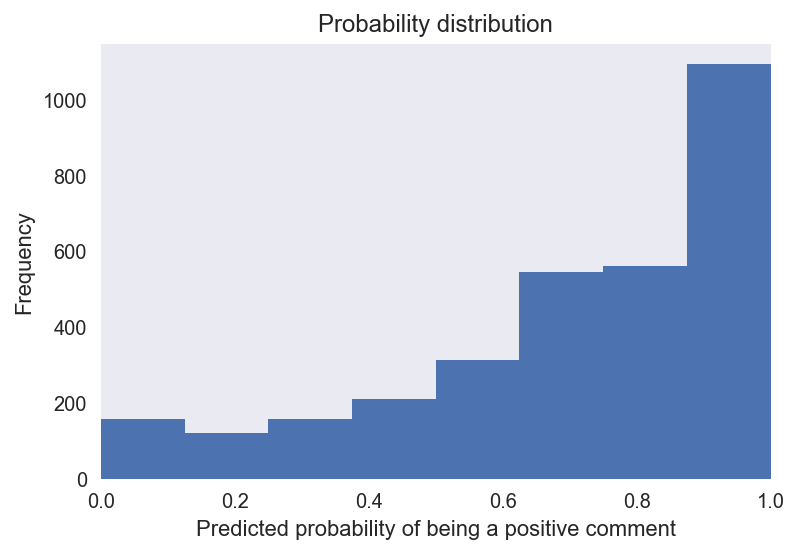

In [108]:
plt.hist(probs_prediction[0][:,1], bins=8)
plt.xlim(0, 1)
plt.title('Probability distribution')
plt.xlabel('Predicted probability of being a positive comment')
plt.ylabel('Frequency')
plt.grid(False);

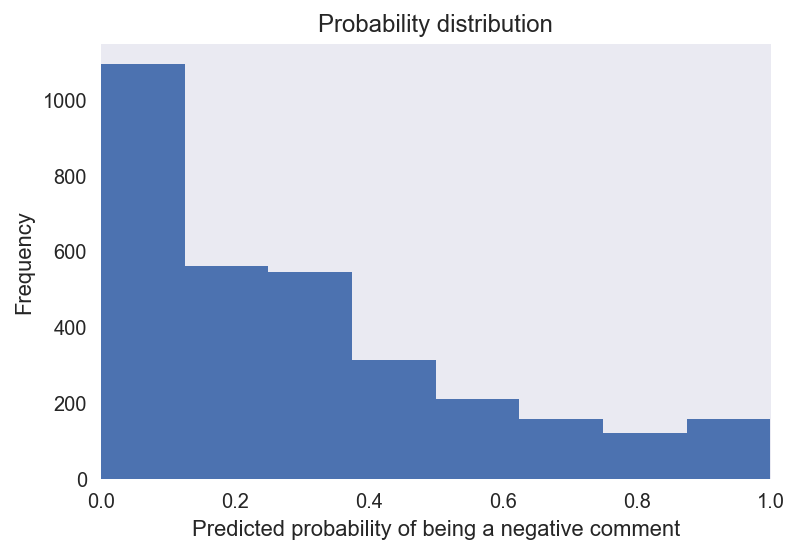

In [109]:
plt.hist(probs_prediction[0][:,0], bins=8)
plt.xlim(0, 1)
plt.title('Probability distribution')
plt.xlabel('Predicted probability of being a negative comment')
plt.ylabel('Frequency')
plt.grid(False);

In [110]:
preds=binarize([probs_prediction[0][:,1]], 0.5)[0]

0.7077903496451998


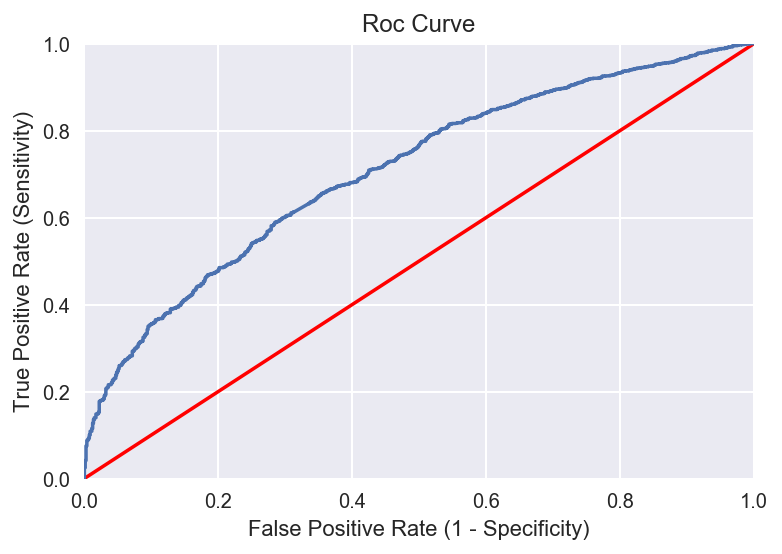

In [112]:
#Data Visualisation of ROC curve :
#equilibrium between True (tpr) and False (fpr) Positive Rate
print(results[0].get('MultinomialNB').get('Roc-Auc'))
line = np.linspace(0, 1, 2)
plt.plot(line, 'r')
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=probs_prediction[0][:,1],pos_label=1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Roc Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True);

### Confusion matrix

In [79]:
# Create confusion matrix
confusion_matrix[1]

Predicted class,0,1,All
Actual class,,,
0,302,508,810
1,343,2004,2347
All,645,2512,3157


### Manual check of the errors

* To understand where is our approcuh failing, we are going to make some manual check of the errors and try to think some strategy to adress this problems


* As we can see, many of the "failures" of the model is because the sentence is actually very obvious that the sentence is negative but it's labeled as positive from the beginning in the data of test (index 12495,8551,11845,etc).


* Also, we can see a lot of sentence that doesn't have a strong negative connonation and are labeled as negative from the beginning, for example: index 3007,6585,467, etc.


* As we can see, the sentiment score calculated using the vader package can help us to re-label the data in a more 
accurate why and then try to build our classifier from the ground

* Another approuch will be to try a topic modeling first and then select a 70-30 of the data for each topic, so every topic be represented in the classifier. Even when this approuch coul be more accurate, introduces a bias over the model and probabibly will fail when a new topic arrives, so we loss generalization

In [80]:
aux=X_test.copy()
aux['real']=y_test
aux['predicted']=preds
aux['acc']=aux.real+aux.predicted
aux=aux[['clean_message','real','predicted','acc','sentiment_score']].copy()
aux.to_csv('classify_test_results.csv',encoding='utf-8',sep=';')

In [81]:
aux[['clean_message','real','predicted','acc','sentiment_score']].head(5)

,clean_message,real,predicted,acc,sentiment_score
12495,Just get back with Tiger and leave the rest of...,1,0.0,1.0,-0.6257
12205,Everyone does have the right to a fair trial !,1,1.0,2.0,0.3802
9764,Yea why should we have to pay for this crap. F...,1,0.0,1.0,-0.1882
9900,"Funny how people can jump on a priest, but not...",0,1.0,1.0,0.6822
5590,Not if there are children involved.,1,1.0,2.0,0.0000


In [82]:
aux=aux[aux.acc==1][['clean_message','real','predicted','sentiment_score']].copy()
aux.to_csv('classify_errors_v2.csv',encoding='utf-8',sep=';')

In [89]:
aux.loc[9764,'clean_message']

'Yea why should we have to pay for this crap. From what I’m reading the people did not have a clue we were paying out for football stadiums while people and vets are sleeping in the streets. That is not Our presidents fault . When and who signed off on all these expenditure.'

In [90]:
cleanText(df.loc[9764,'message'])

'Yea why should we have to pay for this crap. From what I’m reading the people did not have a clue we were paying out for football stadiums while people and vets are sleeping in the streets. That is not Our presidents fault . When and who signed off on all these expenditure.'

In [91]:
aux.head(50)

,clean_message,real,predicted,sentiment_score
12495,Just get back with Tiger and leave the rest of...,1,0.0,-0.6257
9764,Yea why should we have to pay for this crap. F...,1,0.0,-0.1882
9900,"Funny how people can jump on a priest, but not...",0,1.0,0.6822
2119,I saw your half naked pictures you did and th...,0,1.0,0.4249
3007,She is doing a great job! She has every right...,0,1.0,0.6892
8196,The viewers already censor the name of those d...,0,1.0,-0.7906
2652,"More taxpayer money spent on an evil spirit, m...",0,1.0,-0.9153
812,Hoping to delay it until they can lose control...,0,1.0,-0.2960
10370,EXACTLY AMONG MANY OTHER REASONS!!!,0,1.0,0.0000
11845,IF THE JUSTICE SYSTEM WAS NOT BOUGHT OUTWHY IN...,1,0.0,-0.6124
